<font size = 15>Mineracao dos dados</font>

In [1]:
# biblotecas para manipulação de dados
import pandas as pd
import numpy as np

#Plottagem de mapas
import geopandas as gpd
import folium

#bibliotecas para os gráficos
import matplotlib.pyplot as plt
import plotnine as gg
import seaborn as sns

#bibliotecas auxiliares
import os
import re
from unidecode import unidecode
from IPython.display import Image,display 

#Biblioteca propria
import sys
sys.path.append("../src/")
from eda.eda import describe,print_df
from io_pyarrow.io_pyarrow import read_table_to_pandas,write_table_from_pandas #leitura e escrita de arquivos csv grandes

%matplotlib inline
%reload_ext watermark
%watermark --iversions

seaborn   : 0.11.1
numpy     : 1.19.5
geopandas : 0.9.0
folium    : 0.12.1
pandas    : 1.3.2
re        : 2.2.1
matplotlib: 3.3.2
json      : 2.0.9
sys       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
plotnine  : 0.8.0



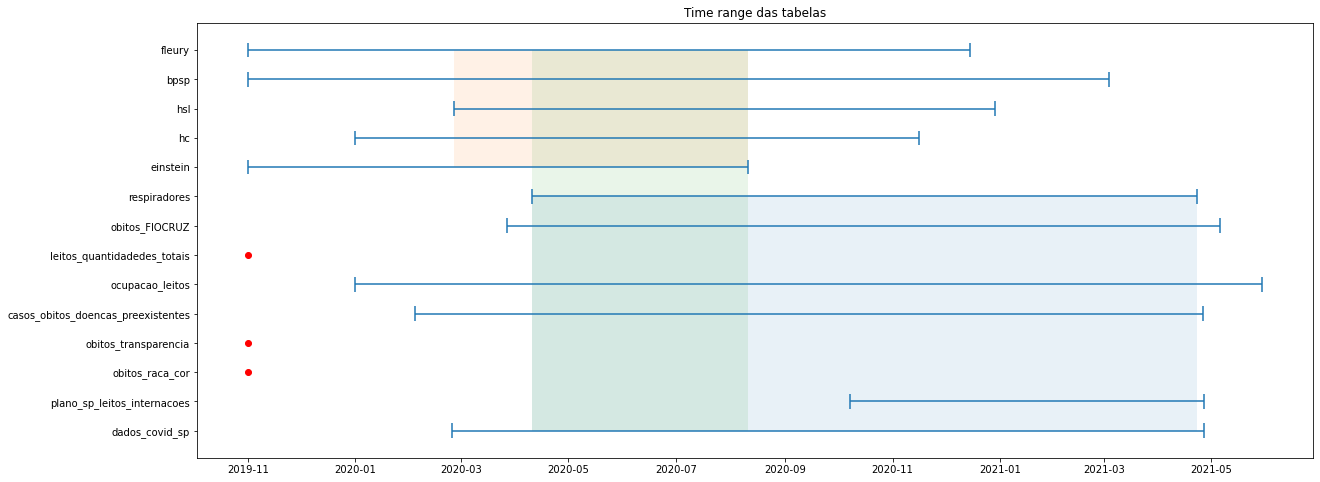

In [2]:
resumo=pd.DataFrame({"Tabela":   ["dados_covid_sp","plano_sp_leitos_internacoes","obitos_raca_cor","obitos_transparencia","casos_obitos_doencas_preexistentes","ocupacao_leitos",                                                      "leitos_quantidadedes_totais","obitos_FIOCRUZ","respiradores","einstein",   "hc",        "hsl",       "bpsp",      "fleury"],
                     "data":     ["S",             "S",                          "N",              "N",                   "S",                                  "S",                                                                   "N",                          "S",             "S",            "S",         "S",         "S",         "S",         "S"],
                     "data_min": ["2020-02-25",    "2020-10-08",                 "",               "",                    "2020-02-04",                         "2020-01-01",                                                          "",                           "2020-03-27",    "2020-04-10",   "2019-11-01","2020-01-01","2020-02-26","2019-11-01","2019-11-01"],
                     "data_max": ["2021-04-27",    "2021-04-27",                 "",               "",                    "2021-04-26",                         "2021-05-30",                                                          "",                           "2021-05-06",    "2021-04-23",   "2020-08-11","2020-11-16","2020-12-29","2021-03-04","2020-12-15"],
                     "Ano":      ["S",             "S",                          "N",              "S",                   "S",                                  "S",                                                                   "S",                          "S",             "S",            "S",         "S",         "S",         "S",         "S"],
                     "municipio":["S",             "N",                          "S",              "N",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "drs":      ["S",             "S",                          "S",              "N",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "uf":       ["S",             "S",                          "S",              "S",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "Obs":      ["",              "",                           "",               "",                    "Data do início dos sintomas",        "Existe CNES e não munip. Realizar join com leitos_quantidades_totais","Há o mês também",            "",              "",             "",          "",          "",          "",          ""]})

resumo.data_min = pd.to_datetime(resumo.data_min)
resumo.data_max = pd.to_datetime(resumo.data_max)

def plot_linha_range_data(Ax,datamin,datamax,y,vline_size=0.25):
    Ax.vlines(ymin=y-vline_size,ymax=y+vline_size,x = datamin)
    Ax.vlines(ymin=y-vline_size,ymax=y+vline_size,x = datamax)
    Ax.hlines(xmin=datamin,xmax=datamax,y=y)

def plot_range_data(df,fill=[]):
    _,Ax = plt.subplots(figsize = (20,8))
    for i,linha in df.iterrows():
        if(linha.data_min != linha.data_min):
            Ax.scatter(df.data_min.min(),i,c="red")
        else:
            plot_linha_range_data(Ax,linha.data_min,linha.data_max,i)

    for area in fill:
        Ax.fill_between(x = [df.query("Tabela == '%s'" % area["tabela_data_min"]).data_min.iloc[0],df.query("Tabela == '%s'" % area["tabela_data_max"]).data_max.iloc[0]],
                        y1 = [df.query("Tabela == '%s'" % area["tabela_y1"]).index[0]]*2,
                        y2 = [df.query("Tabela == '%s'" % area["tabela_y2"]).index[0]]*2,
                        alpha=0.1)

    Ax.set_yticks(range(df.shape[0]))
    Ax.set_yticklabels(df.Tabela.tolist())
    Ax.set_title("Time range das tabelas")
    plt.show()
    
plot_range_data(resumo,[{"tabela_data_min":"respiradores",
                         "tabela_data_max": "respiradores",
                         "tabela_y1": "respiradores",
                         "tabela_y2": "dados_covid_sp"},
                        {"tabela_data_min":"hsl",
                         "tabela_data_max": "einstein",
                         "tabela_y1": "fleury",
                         "tabela_y2": "einstein"},
                        {"tabela_data_min":"respiradores",
                         "tabela_data_max": "einstein",
                         "tabela_y1": "fleury",
                         "tabela_y2": "dados_covid_sp"}])

__Neste jupyter notebook iremos analisar os dados pertencentes às tabelas e aos períodos da área em <font color = green>verde</font>, ou seja, o período de intersecção entre os dados de casos e exames. Abaixo, encontra-se o dicionário de dados da tabela *casos_exames.parquet*__

            
<table>
    <thead>
        <tr> <th>Tabela de origem <th>Fonte <th>Coluna <th> Descrição
    </thead>
    <tbody>
        <tr> <td rowspan=15>Painel da COVID 
             <td rowspan=15>
                  <a href="https://bigdata.icict.fiocruz.br/covid-19">
                    <div style="height:100%;width:100%">
                      https://bigdata.icict.fiocruz.br/covid-19
                    </div>
                  </a> 
            <td>regiao_FIOCRUZ 
            <td>Região do Brasil
        <tr>
            <td>estado_FIOCRUZ
            <td>Estado do município
        <tr>
            <td>municipio_FIOCRUZ 
            <td>Nome do município
        <tr> 
            <td>coduf_FIOCRUZ 
            <td>Código da Unidade Federativa
        <tr> 
            <td>codmun_FIOCRUZ 
            <td>Código do município
        <tr> 
            <td>codRegiaoSaude_FIOCRUZ 
            <td>Código da Regional de Saúde a que o Município de residência do paciente pertence
        <tr> 
            <td>nomeRegiaoSaude_FIOCRUZ
            <td>Nome da Regional de Saúde a que o Município de residência do paciente pertence
        <tr> 
            <td>data_FIOCRUZ
            <td>Data referente aos casos diagnosticados
        <tr> 
            <td>semanaEpi_FIOCRUZ
            <td>Número da n-ésima semana da pandemia
        <tr> 
            <td>populacaoTCU2019_FIOCRUZ
            <td>População do município estimada para o ano de 2019
        <tr> 
            <td>casosAcumulado_FIOCRUZ
            <td>Quantidade de casos acumulado ao longo de toda a pandemia para aquele município
        <tr> 
            <td>casosNovos_FIOCRUZ
            <td>Os novos casos daquele dia para aquele município
        <tr> 
            <td>obitosAcumulado_FIOCRUZ
            <td>Quantidade de óbitos acumulados ao longo de toda a pandemia para aquele município
        <tr> 
            <td>obitosNovos_FIOCRUZ
            <td>Os novos óbitos daquele dia para aquele município
        <tr> 
            <td>interior_metropolitana_FIOCRUZ
            <td>Classificação se a cidade pertence ao interior ou a uma região metropolitana
        <tr> 
            <td rowspan=28>COVID-19 EM SP 
             <td rowspan=45>
                  <a href="https://www.seade.gov.br/coronavirus/">
                    <div style="height:100%;width:100%">
                      https://www.seade.gov.br/coronavirus/
                    </div>
                  </a> 
            <td>codigo_ibge_sp 
            <td>Código do IBGE para aquela cidade       
        <tr> 
            <td>dia_sp
            <td>Data de preenchimento da ficha de notificação
        <tr> 
            <td>mes_sp
            <td>Referido mês do preenchimento da ficha de notificação
        <tr> 
            <td>casos_sp
            <td>Casos totais registrados até a data
        <tr> 
            <td>casos_novos_sp
            <td>Novos casos do referido dia no município
        <tr> 
            <td>casos_pc_sp
            <td>Casos totais por 100 mil habitantes        
        <tr> 
            <td>casos_mm7d_sp
            <td>Média móvel dos últimos 7 dias dos novos casos
        <tr> 
            <td>obitos_sp
            <td>Óbitos totais registrados até a data
        <tr> 
            <td>obitos_novos_sp
            <td>Óbitos novos registrados na data
        <tr> 
            <td>obitos_pc_sp
            <td>Óbitos totais por 100 mil habitantes
        <tr> 
            <td>obitos_mm7d_sp
            <td>Média móvel dos últimos 7 dias dos novos óbitos        
        <tr> 
            <td>letalidade_sp
            <td>casos / obitos
        <tr> 
            <td>nome_ra_sp
            <td>Nome da Região Administrativa
        <tr> 
            <td>cod_ra_sp
            <td>Código da Região Administrativa
        <tr> 
            <td>nome_drs_sp
            <td>Nome do Dpto. Regional de Saúde
        <tr> 
            <td>cod_drs
            <td>Código do Dpto. Regional de Saúde      
        <tr> 
            <td>pop_sp
            <td>População Estimada (fonte: SEADE)         
        <tr> 
            <td>pop_60_sp
            <td>População acima de 60 anos (fonte: SEADE)          
        <tr> 
            <td>area_sp
            <td>Área do município em Km²
        <tr> 
            <td>map_leg_sp
            <td>Rótulo da legenda para mapa        
        <tr> 
            <td>map_leg_s_sp
            <td>Código da legenda para mapa        
        <tr> 
            <td>latitude
            <td>Latitude        
        <tr> 
            <td>longitude
            <td>Longitude        
        <tr> 
            <td>semana_epidem
            <td>Semana Epidemológica        
        <tr> 
            <td>Municípios_sp
            <td>Nome dos municípios de SP normalizados para realização do join       
        <tr> 
            <td>densi_pop_sp
            <td>População / Area
        <tr> 
            <td>densi_pop_60_sp
            <td>População acima de 60 anos / Area
        <tr> 
            <td>perc_60_sp
            <td>População acima de 60 anos / População
        <tr> 
            <td rowspan=17>COMORBIDADES 
            <td>codigo_ibge_pre 
            <td>Código do IBGE para aquela cidade
        <tr> 
            <td>idade_pre
            <td>Idade do paciente notificado com COVID-19
        <tr> 
            <td>cs_sexo_pre
            <td>Gênero do paciente
        <tr> 
            <td>obito_pre
            <td>Paciente veio a óbito? Sim(1)/Não(0)
        <tr> 
            <td>asma_pre
            <td>Constatação se o paciente possui asma        
        <tr> 
            <td>cardiopatia_pre
            <td>Constatação se o paciente possui alguma cardiopatia        
        <tr> 
            <td>diabetes_pre
            <td>Constatação se o paciente possui diabetes        
        <tr> 
            <td>doenca_hematologica_pre
            <td>Constatação se o paciente possui alguma doença hematológica        
        <tr> 
            <td>doenca_hepatica_pre
            <td>Constatação se o paciente possui alguma doença hepática        
        <tr> 
            <td>doenca_neurologica_pre
            <td>Constatação se o paciente possui alguma doença neurológica        
        <tr> 
            <td>doenca_renal_pre
            <td>Constatação se o paciente possui alguma doença renal        
        <tr> 
            <td>imunodepressao_pre
            <td>Constatação se o paciente possui imunodepressão        
        <tr> 
            <td>obesidade_pre
            <td>Constatação se o paciente é obeso       
        <tr> 
            <td>outros_fatores_de_risco_pre
            <td>Constatação se o paciente possui outros fatores de risco        
        <tr> 
            <td>pneumopatia_pre
            <td>Constatação se o paciente possui alguma pneumopatia       
        <tr> 
            <td>sindrome_de_down_pre
            <td>Constatação se o paciente possui síndrome de Down
        <tr> 
            <td>estado
            <td>UF do paciente
        <tr> 
            <td rowspan=6>RESPIRADORES 
            <td rowspan=6>
                  <a href="https://opendatasus.saude.gov.br/dataset">
                    <div style="height:100%;width:100%">
                      https://opendatasus.saude.gov.br/dataset
                    </div>
                  </a> 
            <td>QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido 
            <td>Quantidade de equipamentos, caso o tipo seja "TRANSPORTE", considerando a data do pedido
        <tr> 
            <td>QUANTIDADE_TIPO_UTI_respiradores_pedido
            <td>Quantidade de equipamentos, caso o tipo seja "UTI", considerando a data do pedido
        <tr> 
            <td>QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_pedido
            <td>Quantidade de equipamentos, caso o tipo seja "USA", considerando a data do pedido        
        <tr> 
            <td>QUANTIDADE_TIPO_TRANSPORTE_respiradores_entrega
            <td>Quantidade de equipamentos, caso o tipo seja "TRANSPORTE", considerando a data da entrega       
        <tr> 
            <td>QUANTIDADE_TIPO_UTI_respiradores_entrega
            <td>Quantidade de equipamentos, caso o tipo seja "UTI", considerando a data da entrega        
        <tr> 
            <td>QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_entrega
            <td>Quantidade de equipamentos, caso o tipo seja "USA", considerando a data da entrega
        <tr> 
            <td rowspan=17>BPSP<br>EINSTEIN<br>FLEURY<br>HC<br>HSL 
            <td rowspan=17>
                  <a href="https://repositoriodatasharingfapesp.uspdigital.usp.br/">
                    <div style="height:100%;width:100%">
                      https://repositoriodatasharingfapesp.uspdigital.usp.br/
                    </div>
                  </a> 
            <td>DE_ORIGEM
            <td>Local de coleta daquele exame
        <tr>
            <td>DE_EXAME
            <td>Descrição do exame realizado
        <tr>
            <td>DE_ANALITO_bpsp
            <td>Descrição do analito
        <tr>
            <td>DE_RESULTADO
            <td>Resultado do exame, associado ao DE_ANALITO
        <tr>
            <td>CD_UNIDADE
            <td>Unidade de Medida utilizada na Metodologia do laboratório específico para analisar o exame
        <tr>
            <td>DE_VALOR_REFERENCIA
            <td>Faixa de valores de referência
        <tr>
            <td>DT_ATENDIMENTO
            <td>Data de realização do atendimento
        <tr>
            <td>DE_TIPO_ATENDIMENTO
            <td>Descrição do tipo de atendimento realizado
        <tr>
            <td>DE_CLINICA
            <td>Descrição da unidade da clínica onde o evento aconteceu. 
        <tr>
            <td>DT_DESFECHO
            <td>Data do desfecho 
        <tr>
            <td>IC_SEXO
            <td>Sexo do Paciente
        <tr>
            <td>AA_NASCIMENTO
            <td>Ano de nascimento do Paciente
        <tr>
            <td>OBITO
            <td>Desfecho de óbito
        <tr>
            <td>AA_NASCIMENTO_ANTES_1930
            <td>Paciente nasceu antes de 1930?
        <tr>
            <td>DE_RESULTADO_NUMERICO
            <td>Se o resultado do exame for um valor numérico, estará nessa coluna
        <tr>
            <td>DE_RESULTADO_NAO_NUMERICO
            <td>Se o resultado do exame não for um valor numérico, estará nessa coluna
    </tbody>
</table>

__Para unir as tabelas, foram utilizadas as informações de data e município. Para as bases da FIOCRUZ e os dados de São Paulo, a data se refere ao dia da notificação dos casos, enquanto que na base de COMORBIDADES, esta data está relacionada ao inicio dos sintomas anotado__

In [3]:
casos_sp = read_table_to_pandas("../data/interim/casos_exames.parquet")

In [4]:
pd.set_option('display.max_rows', 150)
describe(casos_sp)

Quantidade de linhas: 124


variable            type  na  \
0                                         data_FIOCRUZ  datetime64[ns]   0   
1                                    semanaEpi_FIOCRUZ           int64   0   
2                                    municipio_FIOCRUZ          object   0   
3                              nomeRegiaoSaude_FIOCRUZ          object   0   
4                             populacaoTCU2019_FIOCRUZ          object   0   
5                               casosAcumulado_FIOCRUZ          object   0   
6                                   casosNovos_FIOCRUZ          object   0   
7                              obitosAcumulado_FIOCRUZ          object   0   
8                                  obitosNovos_FIOCRUZ          object   0   
9                                             casos_sp          object   0   
10                                      casos_novos_sp          object   0   
11                                         casos_pc_sp          object   0   
12                                       casos_mm7d_sp          object   0   
13                                           obitos_sp          object   0   
14                                     obitos_novos_sp          object   0   
15                                        obitos_pc_sp          object   0   
16                                      obitos_mm7d_sp          object   0   
17                                       letalidade_sp          object   0   
18                                          nome_ra_sp          object   0   
19                                           cod_ra_sp          object   0   
20                                         nome_drs_sp          object   0   
21                                          cod_drs_sp          object   0   
22                                              pop_sp          object   0   
23                                           pop_60_sp          object   0   
24                                          map_leg_sp          object   0   
25                                        map_leg_s_sp          object   0   
26                                         latitude_sp          object   0   
27                                        longitude_sp          object   0   
28                                          perc_60_sp          object   0   
29                                        densi_pop_sp          object   0   
30                                     densi_pop_60_sp          object   0   
31                                           idade_pre          object   0   
32                                         cs_sexo_pre          object   0   
33                                           obito_pre          object   0   
34                                            asma_pre          object   0   
35                                     cardiopatia_pre          object   0   
36                                        diabetes_pre          object   0   
37                             doenca_hematologica_pre          object   0   
38                                 doenca_hepatica_pre          object   0   
39                              doenca_neurologica_pre          object   0   
40                                    doenca_renal_pre          object   0   
41                                  imunodepressao_pre          object   0   
42                                       obesidade_pre          object   0   
43                         outros_fatores_de_risco_pre          object   0   
44                                     pneumopatia_pre          object   0   
45                                        puerpera_pre          object   0   
46                                sindrome_de_down_pre          object   0   
47      QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido          object   0   
48             QUANTIDADE_TIPO_UTI_respiradores_pedido          object   0   
49   QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_pe...          object   0   
50     QUANTIDADE_TIPO_TRANSPORTE_respiradores_entrega          obje

Para esses casos, vamos estudar apenas a cidade de São Paulo e seus arredores. Essa região foi selecionada pois:
* A base de dados do SEADE contemplar exatamente municípios do estado de São Paulo;
* A região ser a mais representativa do estado, populacionalmente;
* As bases de dados das instituições possuem pacientes de várias regiões do Brasil, mas a concentração de pacientes encontra-se em São Paulo, Rio de Janeiro e Recife, como pode ser observado nos mapas abaixo:



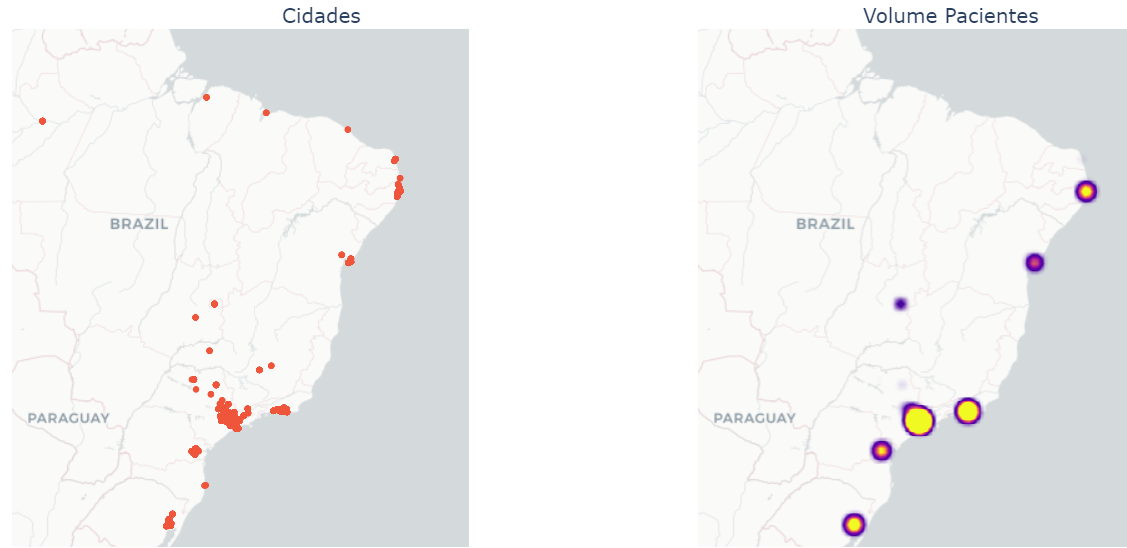

In [5]:
display(Image(filename="../data/image/localidades_pacientes_exames_periodo_verde.png"))

In [6]:
geo = gpd.read_file("../data/raw/Shapefile_Brasil/BR_Municipios_2020.shp")
geo_sp = geo.query("SIGLA_UF == 'SP'")
geo_sp = geo_sp.assign(municipio = lambda x: x.NM_MUN.apply(lambda y: unidecode(y.upper()))).merge(casos_sp.explode(["municipio_FIOCRUZ","nomeRegiaoSaude_FIOCRUZ"])[['municipio_FIOCRUZ','nomeRegiaoSaude_FIOCRUZ']].drop_duplicates(),
                                                                                          right_on = 'municipio_FIOCRUZ',
                                                                                          left_on = 'municipio').drop(columns = "municipio_FIOCRUZ")

In [7]:
colormap = pd.Series(['red','blue','green','yellow','black','magenta'],index=casos_sp.nomeRegiaoSaude_FIOCRUZ.explode().unique()).to_dict()
query_arredores_sp = "nomeRegiaoSaude_FIOCRUZ == 'SAO PAULO' | nomeRegiaoSaude_FIOCRUZ == 'ALTO DO TIETE' | nomeRegiaoSaude_FIOCRUZ == 'FRANCO DA ROCHA' | 'GRANDE ABC' == nomeRegiaoSaude_FIOCRUZ | 'MANANCIAIS' == nomeRegiaoSaude_FIOCRUZ | 'ROTA DOS BANDEIRANTES' == nomeRegiaoSaude_FIOCRUZ"

In [8]:
def style_func(x):
    return {'fillColor': colormap[x["properties"]['nomeRegiaoSaude_FIOCRUZ']],'weight':0.1, "fillOpacity": 0.5}


m_sp = folium.Map(location=[-22, -48], zoom_start=7, tiles='CartoDB positron')
folium.GeoJson(geo_sp.dissolve(),
               style_function = lambda x: {'fillColor': "white"}
              ).add_to(m_sp)
folium.GeoJson(geo_sp.query(query_arredores_sp),
               style_function=style_func,
               tooltip=folium.GeoJsonTooltip(fields=['NM_MUN', 'nomeRegiaoSaude_FIOCRUZ'],
                                             aliases=['NM_MUN', 'nomeRegiaoSaude_FIOCRUZ'],
                                             localize=True)
              ).add_to(m_sp)
print("Está será a região selecionada, contendo São Paulo e cidades em torno")
m_sp

Está será a região selecionada, contendo São Paulo e cidades em torno


In [9]:
colunas_explode = ["municipio_FIOCRUZ", "nomeRegiaoSaude_FIOCRUZ", "populacaoTCU2019_FIOCRUZ", 'casosAcumulado_FIOCRUZ',
                  'casosNovos_FIOCRUZ', 'obitosAcumulado_FIOCRUZ','obitosNovos_FIOCRUZ','casos_sp',
                  'casos_novos_sp', 'casos_pc_sp', 'casos_mm7d_sp',
                   'obitos_sp', 'obitos_novos_sp', 'obitos_pc_sp', 'obitos_mm7d_sp',
                   'letalidade_sp', 'nome_ra_sp', 'cod_ra_sp', 'nome_drs_sp', 'cod_drs_sp',
                   'pop_sp', 'pop_60_sp', 'map_leg_sp', 'map_leg_s_sp', 'latitude_sp',
                   'longitude_sp','perc_60_sp','densi_pop_sp', 'densi_pop_60_sp',
                  'idade_pre', 'cs_sexo_pre', 'obito_pre', 'asma_pre', 'cardiopatia_pre',
                   'diabetes_pre', 'doenca_hematologica_pre', 'doenca_hepatica_pre',
                   'doenca_neurologica_pre', 'doenca_renal_pre', 'imunodepressao_pre',
                   'obesidade_pre', 'outros_fatores_de_risco_pre', 'pneumopatia_pre',
                   'puerpera_pre', 'sindrome_de_down_pre',
                  'QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido',
                   'QUANTIDADE_TIPO_UTI_respiradores_pedido',
                   'QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_pedido',
                   'QUANTIDADE_TIPO_TRANSPORTE_respiradores_entrega',
                   'QUANTIDADE_TIPO_UTI_respiradores_entrega',
                   'QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_entrega']
casos_sp_ = casos_sp.explode(colunas_explode).query(query_arredores_sp).reset_index(drop=True)

As cidades a serem analisadas neste estudo são as seguintes. Além disso, o período de análise compreende, conforme informação acima, entre os dias <font color = green><b>10/04/2020</b></font> e <font color = green><b>11/08/2021</b></font>

In [10]:
casos_sp_.municipio_FIOCRUZ.unique()

array(['ARUJA', 'BARUERI', 'BIRITIBA MIRIM', 'CAIEIRAS', 'CAJAMAR',
       'CARAPICUIBA', 'COTIA', 'DIADEMA', 'EMBU DAS ARTES', 'EMBU-GUACU',
       'FERRAZ DE VASCONCELOS', 'FRANCISCO MORATO', 'FRANCO DA ROCHA',
       'GUARAREMA', 'GUARULHOS', 'ITAPECERICA DA SERRA', 'ITAPEVI',
       'ITAQUAQUECETUBA', 'JANDIRA', 'JUQUITIBA', 'MAIRIPORA', 'MAUA',
       'MOGI DAS CRUZES', 'OSASCO', 'PIRAPORA DO BOM JESUS', 'POA',
       'RIBEIRAO PIRES', 'RIO GRANDE DA SERRA', 'SALESOPOLIS',
       'SANTA ISABEL', 'SANTANA DE PARNAIBA', 'SANTO ANDRE',
       'SAO BERNARDO DO CAMPO', 'SAO CAETANO DO SUL',
       'SAO LOURENCO DA SERRA', 'SAO PAULO', 'SUZANO', 'TABOAO DA SERRA',
       'VARGEM GRANDE PAULISTA'], dtype=object)

In [11]:
describe(casos_sp_)

Quantidade de linhas: 4836


variable            type    na  \
0                                         data_FIOCRUZ  datetime64[ns]     0   
1                                    semanaEpi_FIOCRUZ           int64     0   
2                                    municipio_FIOCRUZ          object     0   
3                              nomeRegiaoSaude_FIOCRUZ          object     0   
4                             populacaoTCU2019_FIOCRUZ          object     0   
5                               casosAcumulado_FIOCRUZ          object     0   
6                                   casosNovos_FIOCRUZ          object     0   
7                              obitosAcumulado_FIOCRUZ          object     0   
8                                  obitosNovos_FIOCRUZ          object     0   
9                                             casos_sp          object     0   
10                                      casos_novos_sp          object     0   
11                                         casos_pc_sp          object     0   
12                                       casos_mm7d_sp          object     0   
13                                           obitos_sp          object     0   
14                                     obitos_novos_sp          object     0   
15                                        obitos_pc_sp          object     0   
16                                      obitos_mm7d_sp          object     0   
17                                       letalidade_sp          object     0   
18                                          nome_ra_sp          object     0   
19                                           cod_ra_sp          object     0   
20                                         nome_drs_sp          object     0   
21                                          cod_drs_sp          object     0   
22                                              pop_sp          object     0   
23                                           pop_60_sp          object     0   
24                                          map_leg_sp          object     0   
25                                        map_leg_s_sp          object     0   
26                                         latitude_sp          object     0   
27                                        longitude_sp          object     0   
28                                          perc_60_sp          object     0   
29                                        densi_pop_sp          object     0   
30                                     densi_pop_60_sp          object     0   
31                                           idade_pre          object   219   
32                                         cs_sexo_pre          object   219   
33                                           obito_pre          object   219   
34                                            asma_pre          object   219   
35                                     cardiopatia_pre          object   219   
36                                        diabetes_pre          object   219   
37                             doenca_hematologica_pre          object   219   
38                                 doenca_hepatica_pre          object   219   
39                              doenca_neurologica_pre          object   219   
40                                    doenca_renal_pre          object   219   
41                                  imunodepressao_pre          object   219   
42                                       obesidade_pre          object   219   
43                         outros_fatores_de_risco_pre          object   219   
44                                     pneumopatia_pre          object   219   
45                                        puerpera_pre          object   219   
46                                sindrome_de_down_pre          object   219   
47      QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido          object  4828   
48             QUANTIDADE_TIPO_UTI_respiradores_pedido          object  4828   
49   QUANTIDADE_TIPO_TRANSPORTE_USA_respirador

Quantidade de linhas: 4836


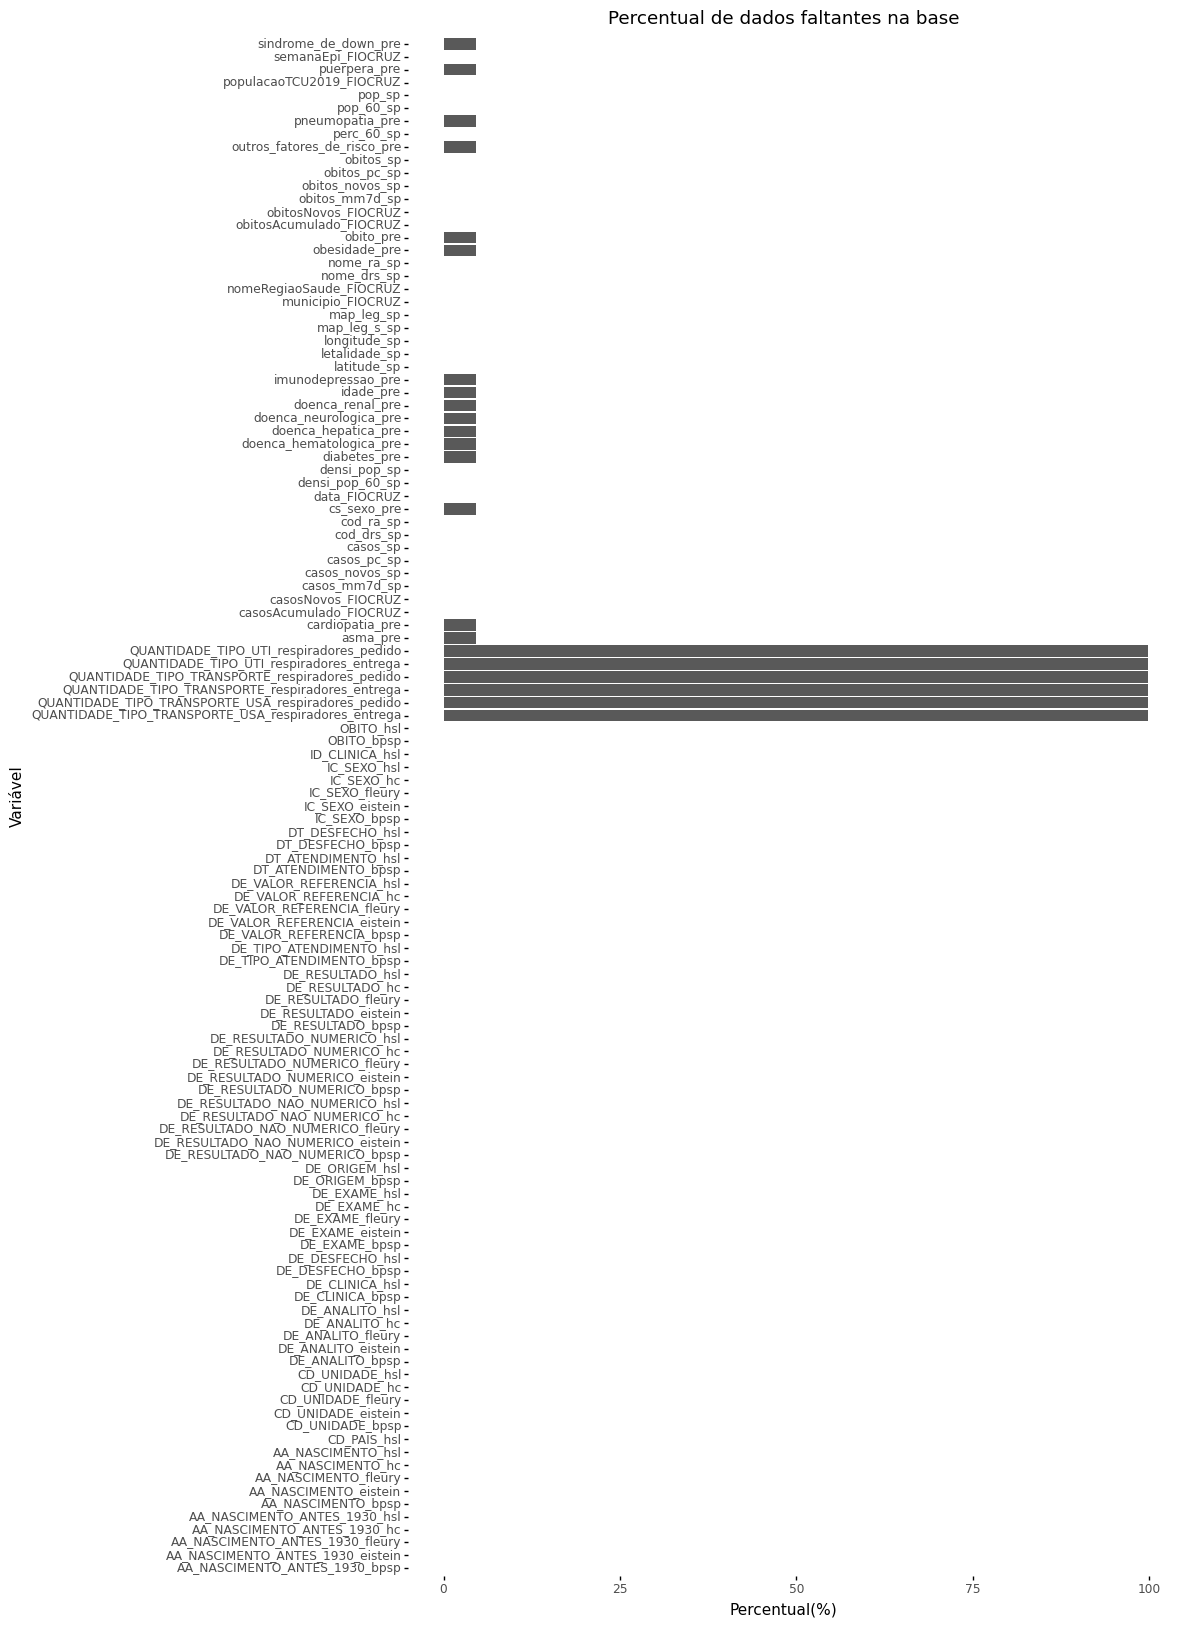

<ggplot: (139925589095)>

In [12]:
resumo_casos_sp_ = describe(casos_sp_).assign(na_pct = lambda x: pd.to_numeric(x["na_pct"].str.replace("%","")))
(
    gg.ggplot(resumo_casos_sp_)
    +gg.geom_col(mapping=gg.aes(x = "variable",y = "na_pct"))
    +gg.coord_flip()
    +gg.theme(figure_size=(10,20), panel_background=gg.element_blank())
    +gg.ggtitle("Percentual de dados faltantes na base")
    +gg.xlab("Variável") + gg.ylab("Percentual(%)")
)

# Mineração dos dados

## Histograma das idades de pessoas que adquiriram a doença

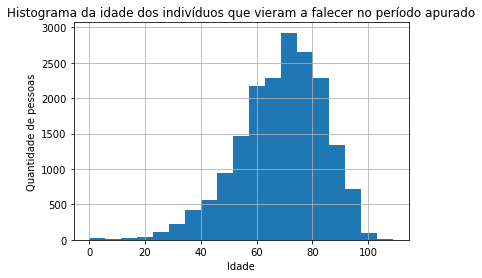

A distribuição de óbitos na região selecionada tem uma cauda a esquerda, evidenciando que a maior parte dos óbitos 
ocorre com pessoas mais velhas


In [13]:
def retorna_dados_lista(name,lista_idade,indice_lista):
    if(len(indice_lista[0]) == 0):
        return np.nan
    else:
        return lista_idade[indice_lista]

def df_explode_idade(df,obito=None):
    return df.query("obito_pre == obito_pre") \
                 .assign(index = lambda x: x["obito_pre"].apply(lambda y: np.where(y == obito) if obito is not None 
                                                                                           else np.where(y >= 0))) \
                 .assign(idade = lambda x: x.apply(lambda y: retorna_dados_lista(y.name,
                                                                                 y['idade_pre'],
                                                                                 y['index']),
                                                         axis=1),
                        sexo = lambda x: x.apply(lambda y: retorna_dados_lista(y.name,
                                                                                 y['cs_sexo_pre'],
                                                                                 y['index']),
                                                         axis=1)).explode(["idade","sexo"])

def hist_individuos_contaminados(df,title,obito=None):
    df_explode_idade(df,obito).idade.hist(bins=19)
    plt.title(title)
    plt.xlabel("Idade")
    plt.ylabel("Quantidade de pessoas")
    plt.show()
    

hist_individuos_contaminados(casos_sp_,"Histograma da idade dos indivíduos que vieram a falecer no período apurado",1)
print("""A distribuição de óbitos na região selecionada tem uma cauda a esquerda, evidenciando que a maior parte dos óbitos 
ocorre com pessoas mais velhas""")

Os casos de óbitos nas cidades arredores de São Paulo seguem uma distribuição de faixa etaria diferente da pirâmide etária do estado de São Paulo, acometendo principalmente os mais idosos

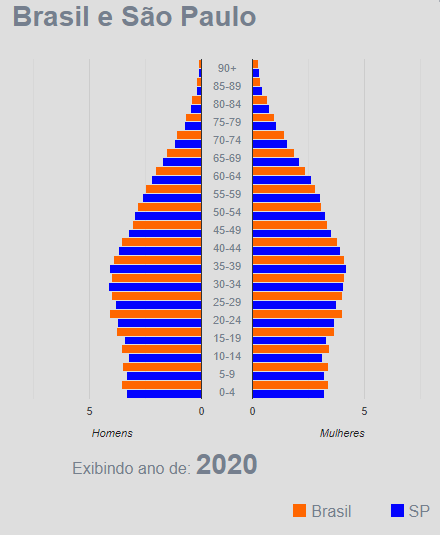

Fonte: https://www.ibge.gov.br/


In [14]:
display(Image(filename="../data/image/piramide_etaria.png"))
print ("Fonte: https://www.ibge.gov.br/")

Vejamos uma pirâmide, só que para as cidades mapeadas em torno da cidade de São Paulo, conforme apresentado no mapa acima

In [15]:
def constroi_faixa_etaria(b):
    fe = []
    for b0,b1 in zip(b,b[1:]):
        if b0 > 0:
            b_menor = b0 + 1
        else:
            b_menor = b0
        b_maior = b1
        
        if b_maior == np.inf:
            fe.append("%s anos ou mais" % (b_menor))
        else:
            fe.append("%s a %s anos"%(b_menor,b_maior))
    
    return fe

In [16]:
piramide = pd.read_excel("../data/raw/Piramide_SP/populacao_censo2010_piramide.xlsx")


    
bins = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,89,99,np.inf]
faixa_etaria = constroi_faixa_etaria(bins)

piramide = piramide.assign(Estado = lambda x: x["Município"].apply(lambda y: re.search("(\()([A-Z]{2})(\))",y).group(2)),
                           Municipio_ = lambda x: x["Município"].apply(lambda y: re.search("(.*)(\()",y).group(1))) \
                   .assign(cidade = lambda x: x["Municipio_"].apply(lambda y: unidecode(y).upper().strip()),
                           Populacao = lambda x: pd.to_numeric(x["Populacao"],errors='coerce').fillna(0))
piramide_ = piramide[piramide.cidade.isin(casos_sp_.municipio_FIOCRUZ.unique())].query("Estado == 'SP'")
piramide_ = piramide_.groupby(["Sexo","Idade"])["Populacao"].sum().reset_index() \
                     .assign(Idade = lambda x: pd.Categorical(x["Idade"],categories=faixa_etaria,ordered=True))
print('Fonte: https://sidra.ibge.gov.br/')
piramide_.head()

Fonte: https://sidra.ibge.gov.br/


Sexo             Idade  Populacao
0  Homens        0 a 4 anos   665324.0
1  Homens      10 a 14 anos   815122.0
2  Homens  100 anos ou mais      386.0
3  Homens      15 a 19 anos   778399.0
4  Homens      20 a 24 anos   874393.0

Nota-se que a pirâmide etária das cidades selecionadas possui alguma semelhança com a pirâmide etária do estado de SP


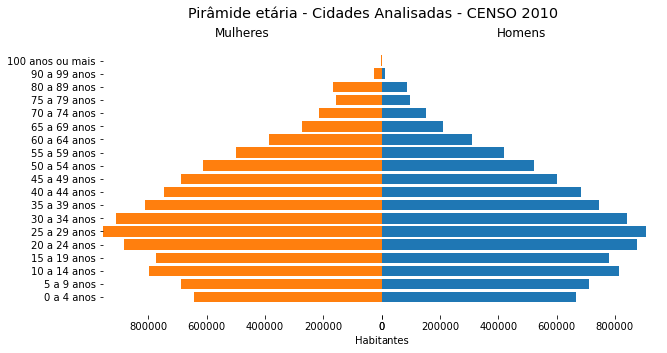

In [17]:
def plot_piramide_etaria(df,qtd,xlabel = "Habitantes",global_title = ""):
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    
    df_ = df.sort_values("Idade")
    
    ax = ax.flatten()
    ax[1].barh(y = df_.query("Sexo == 'Homens'").Idade, 
               width = df_.query("Sexo == 'Homens'")[qtd])
    ax[1].set_xlim([0,df_[qtd].max()])
    ax[1].set(frame_on=False)
    ax[1].set_title("Homens")
    ax[1].get_yaxis().set_visible(False)
    

    ax[0].barh(y = df_.query("Sexo == 'Mulheres'").Idade, 
               width = df_.query("Sexo == 'Mulheres'")[qtd],color='C1')
    ax[0].set_xlim([0,df_[qtd].max()])
    ax[0].invert_xaxis()
    ax[0].set(frame_on=False)
    ax[0].set_title("Mulheres")
    fig.subplots_adjust(wspace  = 0.)
    meio_xlabel = int(len(xlabel)/2)
    ax[0].set_xlabel(xlabel[:meio_xlabel],loc = 'right')
    ax[1].set_xlabel(xlabel[meio_xlabel:],loc = 'left')
    fig.suptitle(global_title, fontsize="x-large")

print("Nota-se que a pirâmide etária das cidades selecionadas possui alguma semelhança com a pirâmide etária do estado de SP")
plot_piramide_etaria(piramide_,"Populacao",global_title = "Pirâmide etária - Cidades Analisadas - CENSO 2010");

Agora, um histograma, não havendo distinção entre gêneros

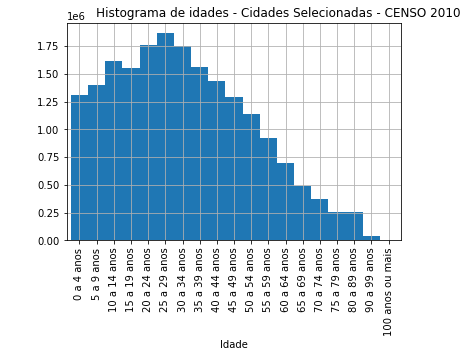

In [18]:
piramide_agrupada = piramide_.groupby("Idade").Populacao.sum().sort_index()
piramide_agrupada.plot(kind='bar',width = 1)
plt.title("                       Histograma de idades - Cidades Selecionadas - CENSO 2010")
plt.grid()
plt.show()

Mesmo com os dados do CENSO de 2010, as diferenças são nítidas, para as cidades selecionadas, quando comparamos com os dados de óbitos: **a curva se difere quando temos o aumento de idade, para os casos de óbitos por COVID**

Vejamos os casos das pessoas que se contaminaram mas não vieram a falecer

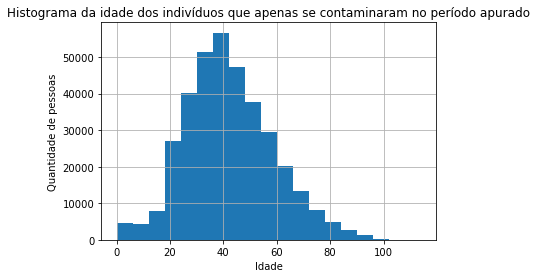

In [19]:
hist_individuos_contaminados(casos_sp_,"Histograma da idade dos indivíduos que apenas se contaminaram no período apurado",0)

Neste cenário, a curva tem uma cauda mais a direita, bem diferente das pessoas que vieram falecer. Ela tende a se assemelhar mais com a pirâmide etária do estado, mas ainda assim o pico ocorre com 40 anos, talvez pela maior exposição ao risco

E o caso de pessoas contaminadas

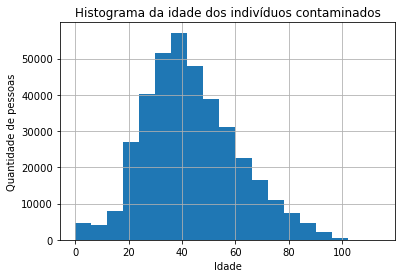

In [20]:
hist_individuos_contaminados(casos_sp_,"Histograma da idade dos indivíduos contaminados")

Como a taxa de óbito da COVID é relativamente pequena, praticamente os dados dos contaminados está relacionado àqueles que apenas se contaminaram e não vieram a falecer

Vamos fazer a normalização dos dados de infectados e óbitos, com base na pirâmide etária das cidades selecionadas

In [21]:
def constroi_faixa_etaria_cut(x):
    if x.right == np.inf:
        return "%d anos ou mais"%(x.left+1)
    else:
        if x.left > 0:
            left = x.left + 1
        else:
            left = x.left
        right = x.right
        return "%d a %d anos"%(left,right)
        
    
def casos_piramide(df,b,fe,obito = None):
    return  df_explode_idade(df,obito).query("idade == idade") \
                             .assign(Faixa_etaria = lambda x: pd.cut(x["idade"],bins=b,include_lowest=True)) \
                             .assign(Faixa_etaria = lambda x: x["Faixa_etaria"] \
                                                                 .apply(lambda y: constroi_faixa_etaria_cut(y)) \
                                                                 .astype("str")) \
                            .assign(Idade = lambda x: pd.Categorical(x['Faixa_etaria'],
                                                                            ordered=True,
                                                                            categories = fe),
                                    Sexo = lambda x: x.sexo.str.replace("masculino","Homens") \
                                                           .str.replace("feminino","Mulheres")) \
                            .groupby(["Idade","Sexo"]).casos_sp.count().reset_index()


casos_sp_piramide_obito = casos_piramide(casos_sp_,bins,faixa_etaria,obito=1)

O gráfico abaixo evidencia que a taxa de mortes entre as pessoas mais velhas é maior que para as pessoas mais 
jovens e seu crescimento se assemelha a uma curva exponencial


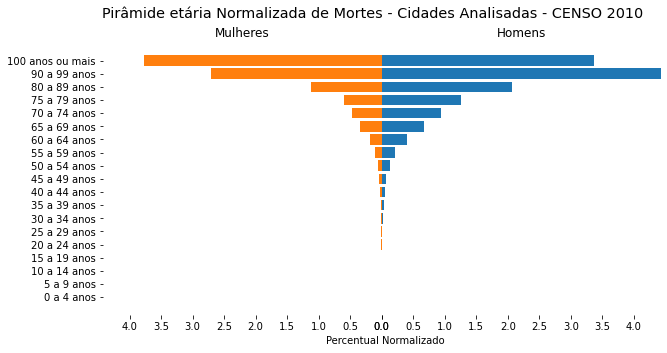

In [22]:
print("""O gráfico abaixo evidencia que a taxa de mortes entre as pessoas mais velhas é maior que para as pessoas mais 
jovens e seu crescimento se assemelha a uma curva exponencial""")
plot_piramide_etaria(casos_sp_piramide_obito.merge(piramide_,
                       how = 'left',
                       on=('Idade','Sexo')).assign(Percentual_casos = lambda x: 100*x["casos_sp"]/x["Populacao"]),
                     "Percentual_casos",
                     xlabel="Percentual Normalizado",
                     global_title = 'Pirâmide etária Normalizada de Mortes - Cidades Analisadas - CENSO 2010');

In [23]:
casos_sp_piramide_casos = casos_piramide(casos_sp_,bins,faixa_etaria)

O gráfico abaixo mostra que as notificações são mais acentuadas nos idosos com mais de 90 anos. Além disso,
as crianças são as que menos se contaminam, relativamente.


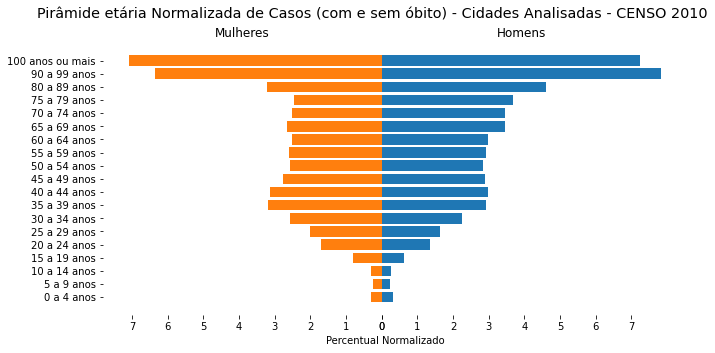

In [24]:
print("""O gráfico abaixo mostra que as notificações são mais acentuadas nos idosos com mais de 90 anos. Além disso,
as crianças são as que menos se contaminam, relativamente.""")
plot_piramide_etaria(casos_sp_piramide_casos.merge(piramide_,
                       how = 'left',
                       on=('Idade','Sexo')).assign(Percentual_casos = lambda x: 100*x["casos_sp"]/x["Populacao"]),
                     "Percentual_casos",
                    xlabel="Percentual Normalizado",
                    global_title = "Pirâmide etária Normalizada de Casos (com e sem óbito) - Cidades Analisadas - CENSO 2010");

In [25]:
casos_sp_piramide_casos_sem_obito = casos_piramide(casos_sp_,bins,faixa_etaria,obito=0)

O gráfico abaixo mostra que as notificações são mais acentuadas nos idosos com mais de 90 anos e 
adultos entre 35 e 44 anos.


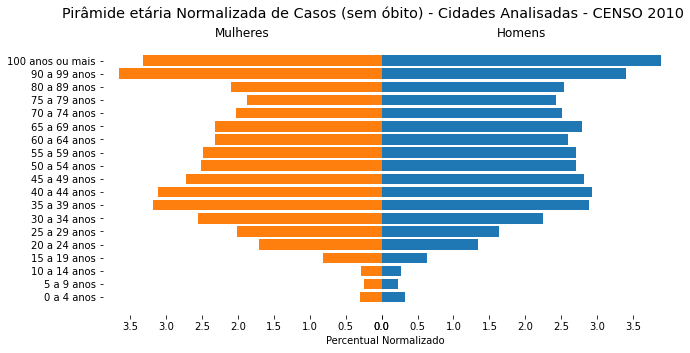

In [26]:
print("""O gráfico abaixo mostra que as notificações são mais acentuadas nos idosos com mais de 90 anos e 
adultos entre 35 e 44 anos.""")
plot_piramide_etaria(casos_sp_piramide_casos_sem_obito.merge(piramide_,
                       how = 'left',
                       on=('Idade','Sexo')).assign(Percentual_casos = lambda x: 100*x["casos_sp"]/x["Populacao"]),
                     "Percentual_casos",
                     xlabel="Percentual Normalizado",
                     global_title = "Pirâmide etária Normalizada de Casos (sem óbito) - Cidades Analisadas - CENSO 2010");

## Taxa de mortalidade

Vamos verificar a quantidade de pessoas que vieram a falecer no período, frente a quantidade de pessoas que vieram a morrer

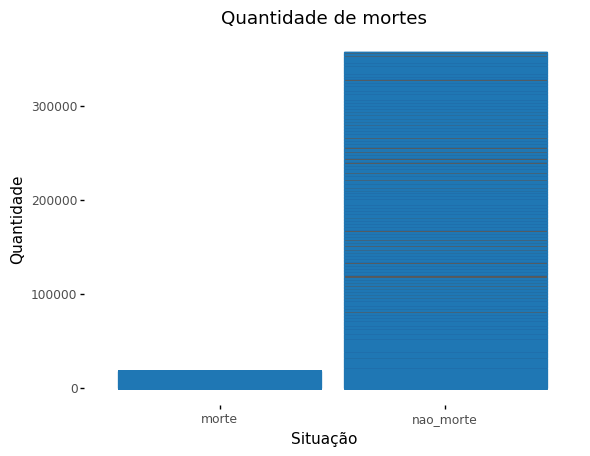

<ggplot: (139971267970)>

In [27]:
casos_sp_ = casos_sp_.assign(nao_morte = lambda x: x["obito_pre"].apply(lambda y: len(np.where(y == 0)[0])),
                             morte = lambda x: x["obito_pre"].apply(lambda y: len(np.where(y == 1)[0])))



def plot_volume_mortes_nao_mortes(df):
    return (
                gg.ggplot(
                            df.melt(id_vars = ["municipio_FIOCRUZ","data_FIOCRUZ"],value_vars = ['nao_morte','morte'],
                                                    var_name = 'situacao',value_name='quantidade')
                )
                +gg.geom_col(gg.aes(x="situacao",y = 'quantidade'),color="C0")
                +gg.theme(panel_background=gg.element_blank())
                +gg.ggtitle("Quantidade de mortes")
                +gg.xlab("Situação")
                +gg.ylab("Quantidade")
           )
    
plot_volume_mortes_nao_mortes(casos_sp_)

In [28]:
print("Vemos que dos casos de contaminados, são 4% aqueles que vem a óbito")
def obitos_nao_obitos_contaminados(df):
    return df.melt(id_vars = ["municipio_FIOCRUZ","data_FIOCRUZ"],value_vars = ['nao_morte','morte'],
                                            var_name = 'situacao',value_name='quantidade') \
             .groupby("situacao").quantidade.sum().reset_index() \
             .assign(perc_quantidade = lambda x: 100*x["quantidade"]/x["quantidade"].sum())

obitos_nao_obitos_contaminados(casos_sp_)

Vemos que dos casos de contaminados, são 4% aqueles que vem a óbito


situacao  quantidade  perc_quantidade
0      morte       18278         4.863059
1  nao_morte      357576        95.136941

## Casos por municipio

In [29]:
def volume_casos(df):
    return df.groupby("municipio_FIOCRUZ").casos_novos_sp.sum().sort_values(ascending=False)
    
volume_casos(casos_sp_)

municipio_FIOCRUZ
SAO PAULO                 211767.0
SAO BERNARDO DO CAMPO      18347.0
GUARULHOS                  13453.0
SANTO ANDRE                12059.0
OSASCO                     10504.0
DIADEMA                     6133.0
CARAPICUIBA                 5008.0
MOGI DAS CRUZES             4600.0
TABOAO DA SERRA             4585.0
BARUERI                     4546.0
MAUA                        4051.0
SAO CAETANO DO SUL          3227.0
SUZANO                      3123.0
ITAQUAQUECETUBA             2958.0
COTIA                       2680.0
EMBU DAS ARTES              2449.0
ITAPEVI                     2446.0
SANTANA DE PARNAIBA         2075.0
FRANCISCO MORATO            1973.0
FERRAZ DE VASCONCELOS       1866.0
ITAPECERICA DA SERRA        1799.0
FRANCO DA ROCHA             1569.0
CAIEIRAS                    1355.0
ARUJA                       1276.0
POA                         1171.0
CAJAMAR                     1138.0
JANDIRA                     1065.0
RIBEIRAO PIRES               901.0
EM

Vamos verificar os casos percentuais, ou seja, a quantidade de casos pela população do municipio

Por conta da cidade de São Paulo ser um outlier no número de habitantes, precisamos fazer uma transformação para
que este problema não seja percebido


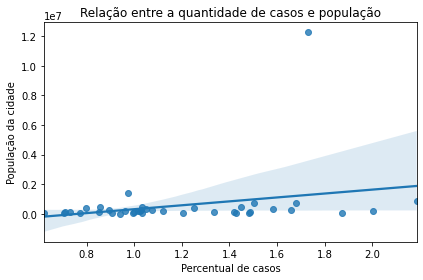

In [30]:
def regplot_perc_log(df,x,y):
    sns.regplot(
        data = df.groupby("municipio_FIOCRUZ").agg({'casos_novos_sp':sum,
                                                    'obitos_novos_sp':sum,
                                                    'populacaoTCU2019_FIOCRUZ':'mean'}) \
                 .assign(perc_casos = lambda x: 100*x["casos_novos_sp"]/x["populacaoTCU2019_FIOCRUZ"],
                         perc_obitos = lambda x: 100*x["obitos_novos_sp"]/x["populacaoTCU2019_FIOCRUZ"]).sort_values('perc_casos') \
                [[x,'populacaoTCU2019_FIOCRUZ']].assign(poplog = lambda x: np.log(x["populacaoTCU2019_FIOCRUZ"])),
        x = x,
        y = y
    )
    plt.title('Relação entre a quantidade de casos e população')
    plt.tight_layout()
    

print("""Por conta da cidade de São Paulo ser um outlier no número de habitantes, precisamos fazer uma transformação para
que este problema não seja percebido""")
regplot_perc_log(casos_sp_,'perc_casos','populacaoTCU2019_FIOCRUZ')
plt.xlabel("Percentual de casos")
plt.ylabel("População da cidade")
plt.show()


Uma hipótese inicial seria que, dado que as cidades são relativamente 'iguais', proporcionalmente, a quantidade de 
casos não teria uma tendência de crescimento (correlação = 0), porém pelo gráfico abaixo vemos uma leve tendência de 
correlação positiva


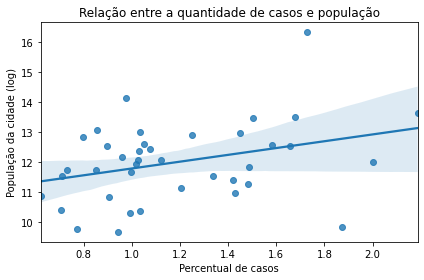

In [31]:
print("""Uma hipótese inicial seria que, dado que as cidades são relativamente 'iguais', proporcionalmente, a quantidade de 
casos não teria uma tendência de crescimento (correlação = 0), porém pelo gráfico abaixo vemos uma leve tendência de 
correlação positiva""")
regplot_perc_log(casos_sp_,'perc_casos','poplog')
plt.xlabel("Percentual de casos")
plt.ylabel("População da cidade (log)")
plt.show()    

Para a quantidade de mortes, temos uma leve correlação positiva mais aparente relacionando a quantidade de pessoas 
na cidade e a quantidade de pessoas que vem a falecer


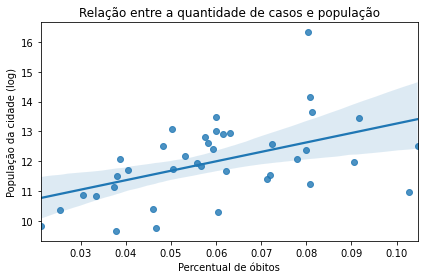

In [32]:
print("""Para a quantidade de mortes, temos uma leve correlação positiva mais aparente relacionando a quantidade de pessoas 
na cidade e a quantidade de pessoas que vem a falecer""")
regplot_perc_log(casos_sp_,'perc_obitos','poplog')

plt.xlabel("Percentual de óbitos")
plt.ylabel("População da cidade (log)")
plt.show()

## Avaliação das comorbidades

In [33]:
comorbidades = ['asma_pre',
                 'cardiopatia_pre',
                 'diabetes_pre',
                 'doenca_hematologica_pre',
                 'doenca_hepatica_pre',
                 'doenca_neurologica_pre',
                 'doenca_renal_pre',
                 'imunodepressao_pre',
                 'obesidade_pre',
                 'outros_fatores_de_risco_pre',
                 'pneumopatia_pre',
                 'puerpera_pre',
                 'sindrome_de_down_pre']

In [34]:
 def explode_comorbidade_df(df):
    explode = df[["municipio_FIOCRUZ","data_FIOCRUZ","obito_pre","cs_sexo_pre","idade_pre"]+comorbidades] \
                             .explode(["idade_pre",'obito_pre','cs_sexo_pre']+comorbidades).reset_index(drop=True) \
                             .assign(alguma_comorbidade = lambda x: (x[comorbidades]=="sim") \
                                                                           .apply(lambda y: any(y),axis=1),
                                     totalmente_ignorado = lambda x: (x[comorbidades]=="ignorado") \
                                                                       .apply(lambda y: all(y),axis=1)) \
                             .assign(alguma_comorbidade = lambda x: np.where(x["alguma_comorbidade"] == True,"sim",
                                                                          np.where(x["totalmente_ignorado"] == True,
                                                                                    "ignorado",
                                                                                    "não")))
    return explode

casos_sp_explode = explode_comorbidade_df(casos_sp_)

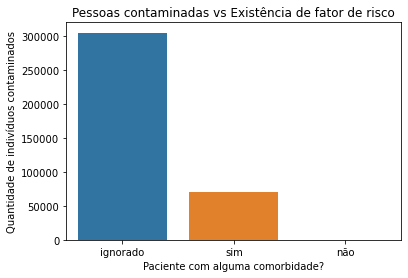

In [35]:
def plot_volume_comorbidades(df):
    sns.countplot(data = df,x = "alguma_comorbidade")
    plt.title("Pessoas contaminadas vs Existência de fator de risco")
    plt.xlabel("Paciente com alguma comorbidade?")
    plt.ylabel("Quantidade de indivíduos contaminados")
    plt.show()

plot_volume_comorbidades(casos_sp_explode)

Vamos verificar o mesmo gráfico, mas agora apenas para os óbitos, pois a quantidade de não óbitos é bem superior

Nota-se que há uma diferença entre ter alguma comorbidade e os casos com óbito: existe uma relação entre eles


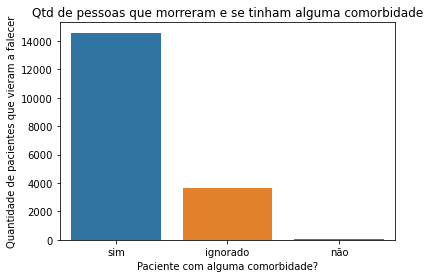

In [36]:
def plot_volume_comorbidades_obito(df):
    sns.countplot(data = df.query("obito_pre == 1"),x = "alguma_comorbidade")
    plt.title("Qtd de pessoas que morreram e se tinham alguma comorbidade")
    plt.xlabel("Paciente com alguma comorbidade?")
    plt.ylabel("Quantidade de pacientes que vieram a falecer")
    plt.show()

print("Nota-se que há uma diferença entre ter alguma comorbidade e os casos com óbito: existe uma relação entre eles")
plot_volume_comorbidades_obito(casos_sp_explode)

Vamos ver se uma comorbidade sobresai

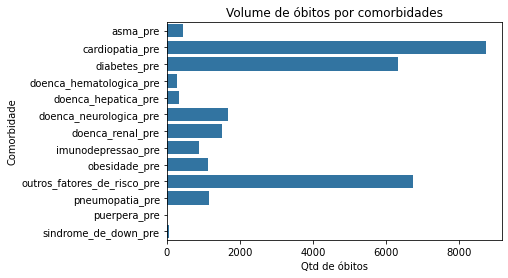

In [37]:
def comorbidades_obitos(df):
    sns.countplot(data = 
                        df.query("obito_pre == 1 & alguma_comorbidade == 'sim'") \
                                        .melt(id_vars=['municipio_FIOCRUZ','data_FIOCRUZ','obito_pre','idade_pre'],
                                               value_vars=comorbidades,
                                               value_name="existencia_comorbidade",
                                               var_name= "comorbidade") \
                                        .query("existencia_comorbidade == 'sim'"),
                 y='comorbidade',
                 color = 'C0')
    plt.title("Volume de óbitos por comorbidades")
    plt.xlabel("Qtd de óbitos")
    plt.ylabel("Comorbidade")
    plt.show()


comorbidades_obitos(casos_sp_explode)

Vamos apenas verificar, nos casos totais, a quantidade de pessoas com essas comorbidades

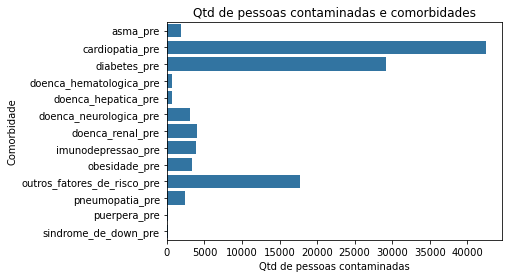

In [38]:
def comorbidades_totais(df):
    sns.countplot(data = 
                        df.query("alguma_comorbidade == 'sim'") \
                                        .melt(id_vars=['municipio_FIOCRUZ','data_FIOCRUZ','obito_pre','idade_pre'],
                                               value_vars=comorbidades,
                                               value_name="existencia_comorbidade",
                                               var_name= "comorbidade") \
                                        .query("existencia_comorbidade == 'sim'"),
                 y='comorbidade',
                 color = 'C0')
    plt.title("Qtd de pessoas contaminadas e comorbidades")
    plt.xlabel("Qtd de pessoas contaminadas")
    plt.ylabel("Comorbidade")
    plt.show()

comorbidades_totais(casos_sp_explode)

Nota-se, a principio, que não necessariamente as cardiopatias estão mais associadas aos óbitos, mas sim que existem mais pessoas cardiopatas. Vamos verificar a relação percentual de cada caso para termos uma noção melhor

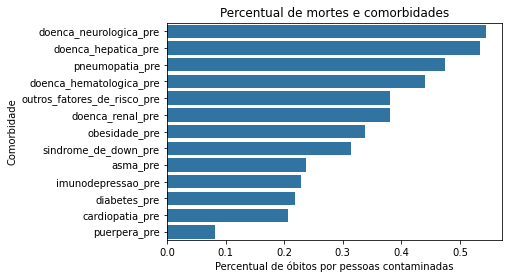

Nota-se, portanto, que doenças neurológicas, hepáticas e pneumáticas ter um percentual maior de acometimento do 
paciente. Por exemplo, percebe-se que, das pessoas diagnosticadas com alguma doença neurológica, 50% vem a óbito


In [39]:
def perc_mortes_comorbidades(df):
    sns.barplot(data = 
    df.query("alguma_comorbidade == 'sim'") \
                                        .melt(id_vars=['municipio_FIOCRUZ','data_FIOCRUZ','obito_pre','idade_pre'],
                                               value_vars=comorbidades,
                                               value_name="existencia_comorbidade",
                                               var_name= "comorbidade") \
                                        .query("existencia_comorbidade == 'sim'") \
                    .pivot_table(index='comorbidade',columns="obito_pre",values="existencia_comorbidade",aggfunc="count") \
                    .rename(columns = {0:"nao_obito",1:"obito"}).assign(perc = lambda x: x["obito"]/(x["obito"]+x["nao_obito"])) \
                    .reset_index().sort_values("perc",ascending=False),
               x = "perc",y = 'comorbidade',color = 'C0')
    plt.title("Percentual de mortes e comorbidades")
    plt.xlabel("Percentual de óbitos por pessoas contaminadas")
    plt.ylabel("Comorbidade")
    plt.show()
perc_mortes_comorbidades(casos_sp_explode)
print("""Nota-se, portanto, que doenças neurológicas, hepáticas e pneumáticas ter um percentual maior de acometimento do 
paciente. Por exemplo, percebe-se que, das pessoas diagnosticadas com alguma doença neurológica, 50% vem a óbito""")

### Taxa por cormobidade

Relação de comorbidades associadas aos óbitos pela Relação de comorbidades associadas à população contaminada

In [40]:
def relacao_comorbidade(df,coluna,aggfunc,coluna_comorbidade):
    relacao = df.groupby(["obito_pre",coluna_comorbidade]).agg({coluna:aggfunc}).reset_index()
                                #quantidade de obitos com comorbidade frente a todos os obitos
    relacao_comorbidade_obito = relacao.query("%s == 'sim' & obito_pre == 1" % coluna_comorbidade) \
                                       [coluna].sum() / relacao.query("obito_pre == 1")[coluna].sum()
    
                                #quantidade de pessoas com comorbidade frente a todos as pessoas contaminadas
    relacao_comorbidade_ = relacao.query("%s == 'sim'" % coluna_comorbidade)[coluna].sum()/relacao[coluna].sum()
    
    prob_cond_Morreu_Comor = relacao.query("%s == 'sim' & obito_pre == 1" % coluna_comorbidade)[coluna] \
                                    .sum()/ relacao.query("%s == 'sim'" % coluna_comorbidade)[coluna].sum()
    
    return (relacao,
            relacao_comorbidade_obito,
            relacao_comorbidade_,
            prob_cond_Morreu_Comor)



In [41]:
_,rco,rc,pM_C = relacao_comorbidade(casos_sp_explode,"idade_pre","count","alguma_comorbidade")

In [42]:
print("RCO = Relação de comorbidades associadas aos óbitos (qtd pessoas com comorbidade que morreram/ qtd de mortes)",
      round(rco*100,1))
print("RC = Relação de comorbidades associadas à população contaminada (qtd comorbidade/qtd contaminada)",round(rc*100,1))
print("Relação RCO/RC",round(rco/rc*100,1))
print("Probabilidade Condicional de Morte, dado que a pessoa tinha Comorbidade",round(pM_C*100,2))

RCO = Relação de comorbidades associadas aos óbitos (qtd pessoas com comorbidade que morreram/ qtd de mortes) 79.8
RC = Relação de comorbidades associadas à população contaminada (qtd comorbidade/qtd contaminada) 18.9
Relação RCO/RC 421.9
Probabilidade Condicional de Morte, dado que a pessoa tinha Comorbidade 20.53


In [43]:
def criar_base_rc_faixa_etaria(df,bins_,coluna_comorbidade):
    b_rc_fe = df.query("idade_pre == idade_pre") \
     .assign(Faixa_etaria = lambda x: pd.cut(x["idade_pre"],bins=bins_,include_lowest=True)) \
                                 .assign(Faixa_etaria = lambda x: x["Faixa_etaria"] \
                                                                     .apply(lambda y: constroi_faixa_etaria_cut(y)) \
                                                                     .astype("str").str \
                                                                                 .replace("nan","%s anos ou mais"%bins_[-1])) \
                                .assign(Idade = lambda x: pd.Categorical(x['Faixa_etaria'],
                                                                                ordered=True,
                                                                                categories = faixa_etaria),
                                        Sexo = lambda x: x.cs_sexo_pre.str.replace("masculino","Homens") \
                                                               .str.replace("feminino","Mulheres")) \
                                .groupby(["Idade","Sexo","obito_pre",coluna_comorbidade]) \
                                .municipio_FIOCRUZ.count().reset_index() \
                                .rename(columns = {"municipio_FIOCRUZ":"casos_sp"})
    return b_rc_fe


def criar_piramide_rc(df,bins_,coluna_comorbidade):
    
    b_rc_fe = criar_base_rc_faixa_etaria(df,bins_,coluna_comorbidade)
    b_rc_fe_alguma_comor = criar_base_rc_faixa_etaria(df,bins_,"alguma_comorbidade")
    
    estrutura_rc_faixa_etaria_alguma_comorbidade = b_rc_fe_alguma_comor.drop_duplicates(["Idade","Sexo"]) \
                                                                       .drop(columns=["obito_pre",
                                                                                      "alguma_comorbidade",
                                                                                      "casos_sp"])
    
    estrutura_rc_faixa_etaria = b_rc_fe.drop_duplicates(["Idade","Sexo"]).drop(columns=["obito_pre",
                                                                                        coluna_comorbidade,
                                                                                        "casos_sp"])
    p_rc = {"Idade":[],"Sexo":[],"RCO":[],"RC":[],"RCORC":[], "pM_C":[], "razao_prob":[]}
    for _,row in estrutura_rc_faixa_etaria.iterrows():
        df_filtrado = b_rc_fe.query("Idade == '%s' & Sexo == '%s'" % (row.Idade,row.Sexo))
        df_filtrado_alguma_comor = b_rc_fe_alguma_comor.query("Idade == '%s' & Sexo == '%s'" % (row.Idade,row.Sexo))
        
        _,rco_i,rc_i,pM_C_i= relacao_comorbidade(df_filtrado,"casos_sp","sum",coluna_comorbidade)
        _,_,_,pM_C_alguma_i= relacao_comorbidade(df_filtrado_alguma_comor,"casos_sp","sum","alguma_comorbidade")
        
        p_rc["Idade"].append(row.Idade)
        p_rc["Sexo"].append(row.Sexo)
        p_rc["RCO"].append(rco_i)
        p_rc["RC"].append(rc_i)
        p_rc["RCORC"].append(rco_i/rc_i)
        p_rc["pM_C"].append(pM_C_i)
        p_rc["razao_prob"].append(pM_C_i/pM_C_alguma_i)
        
    return pd.DataFrame(p_rc).assign(Idade = lambda x: pd.Categorical(x['Idade'],
                                                                      ordered=True,
                                                                      categories = faixa_etaria))

In [44]:
piramide_rc = criar_piramide_rc(casos_sp_explode,bins,'alguma_comorbidade')

<ipython-input-40-c20cf16a40ef>:4: RuntimeWarning: invalid value encountered in longlong_scalars
<ipython-input-43-7271a71d6057>:46: RuntimeWarning: invalid value encountered in double_scalars


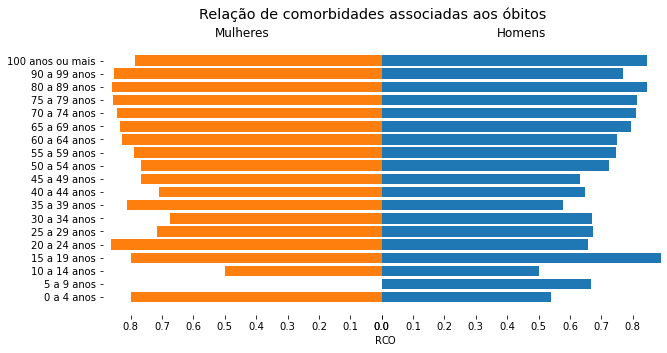

In [45]:
plot_piramide_etaria(piramide_rc,"RCO","RCO",
                     global_title="Relação de comorbidades associadas aos óbitos")

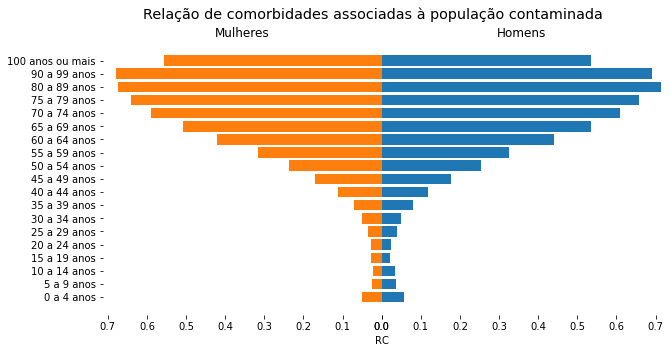

In [46]:
plot_piramide_etaria(piramide_rc,"RC","RC",
                    global_title = 'Relação de comorbidades associadas à população contaminada')

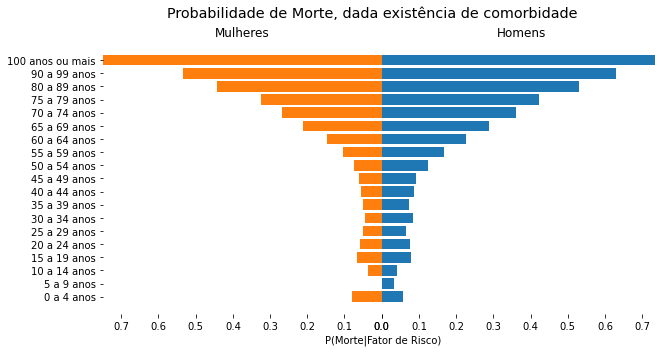

In [47]:
plot_piramide_etaria(piramide_rc,"pM_C","P(Morte|Fator de Risco)",
                     global_title="Probabilidade de Morte, dada existência de comorbidade")

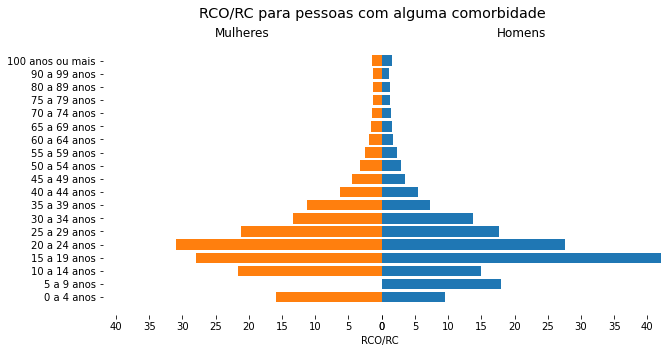

In [48]:
plot_piramide_etaria(piramide_rc,"RCORC","RCO/RC",global_title="RCO/RC para pessoas com alguma comorbidade")

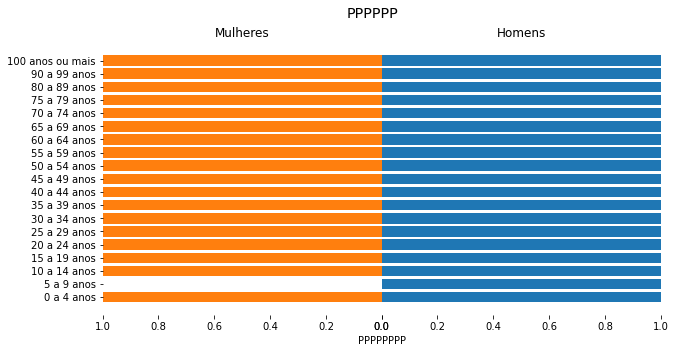

In [49]:
plot_piramide_etaria(piramide_rc,"razao_prob","PPPPPPPP",
                     global_title="PPPPPP")

### Taxa por cada uma das comorbidades

In [91]:
def plot_piramides_rc_faixa_etaria_comorbidade(df,bins_,coluna_comorbidade,nome_comorbidade=""):
    if nome_comorbidade == "":
        nome_comorbidade = coluna_comorbidade

    prc = criar_piramide_rc(df,bins_,
                            coluna_comorbidade)
    plot_piramide_etaria(prc,
                         "RCO",
                         "RCO",
                         global_title = nome_comorbidade.upper() + " - Relação de comorbidades associadas aos óbitos")

    plot_piramide_etaria(prc,
                         "RC",
                         "RC",
                         global_title = nome_comorbidade.upper() 
                                        + " - Relação de comorbidades associadas à população contaminada")

    plot_piramide_etaria(prc,
                         "RCORC",
                         "RCO/RC",
                         global_title = nome_comorbidade.upper() + " - RCO/RC")
    
    plot_piramide_etaria(prc,
                         "pM_C",
                         "P(Morte|Fator de Risco)",
                         global_title = nome_comorbidade.upper() + " - P(Morte|Fator de Risco)")

#### ASMA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


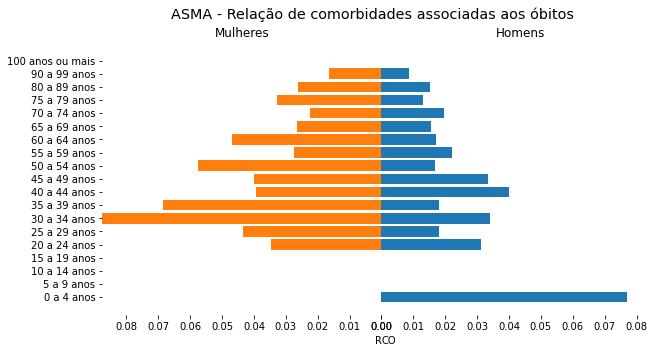

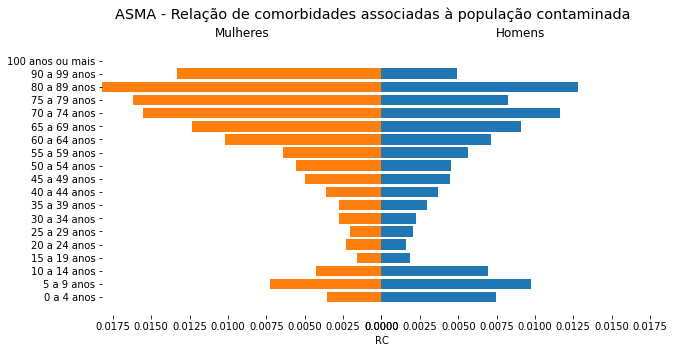

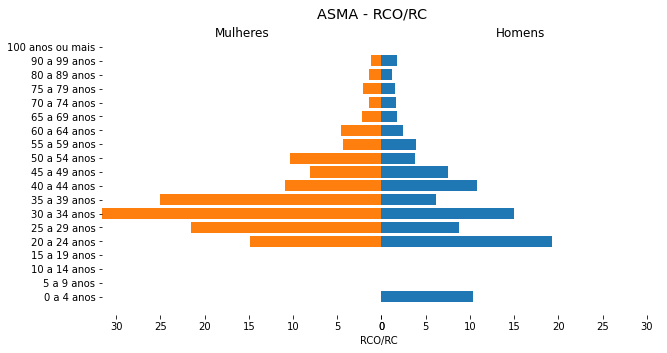

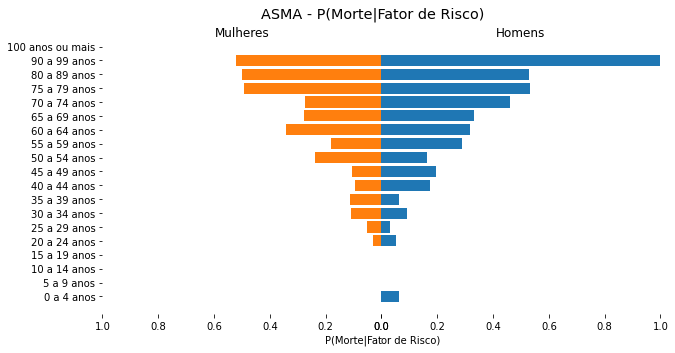

In [92]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'asma_pre','asma')

####  DIABETES

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


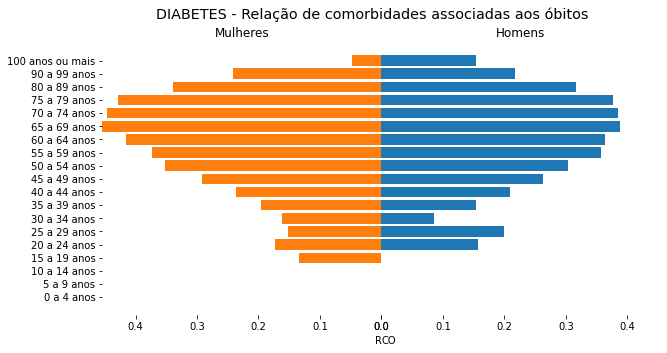

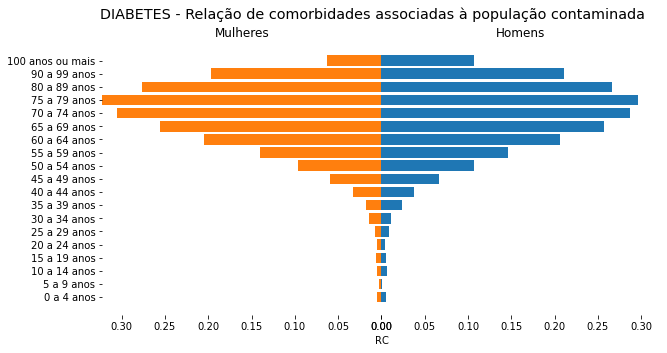

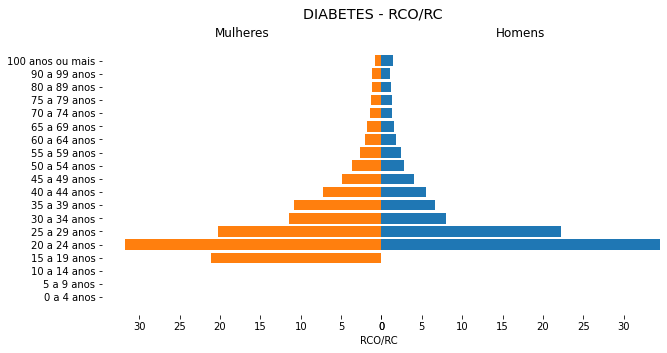

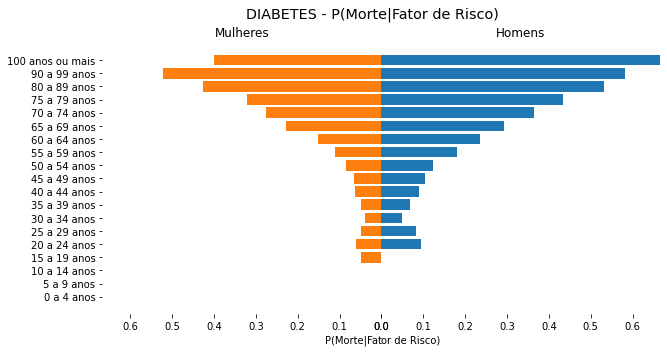

In [93]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'diabetes_pre',"diabetes")

####  DOENÇA HEMATOLOGICA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


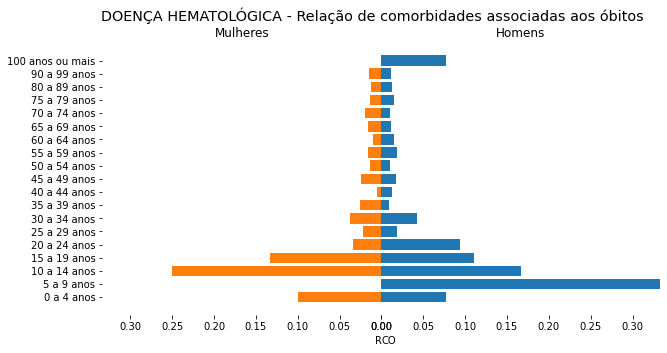

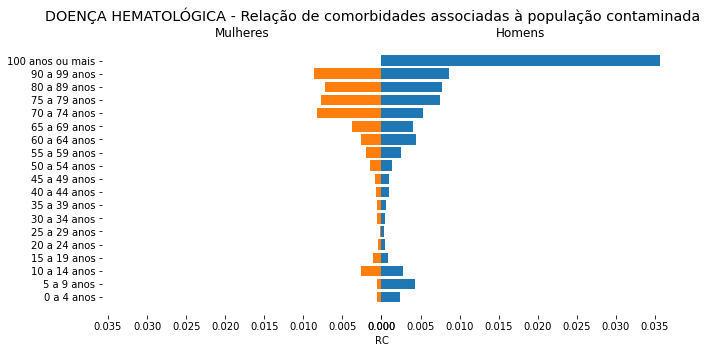

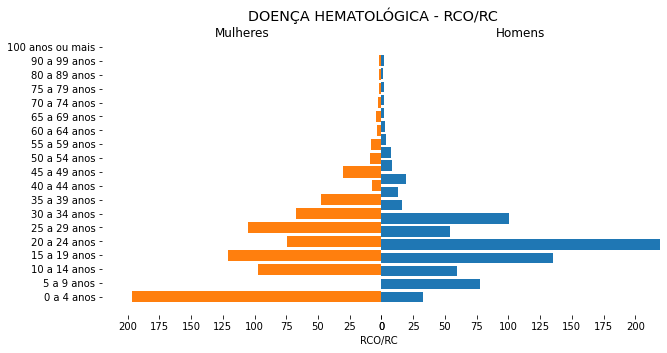

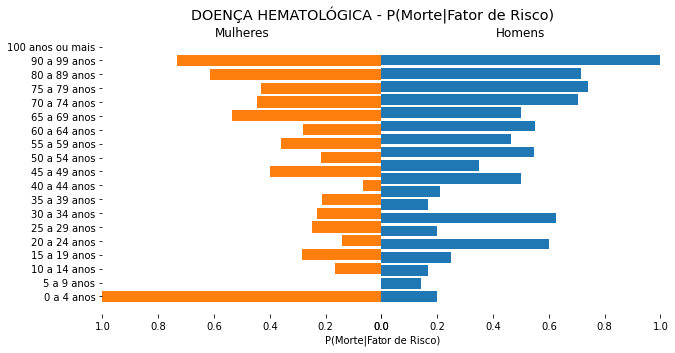

In [94]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'doenca_hematologica_pre',"doença hematológica")

####  DOENCA HEPATICA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


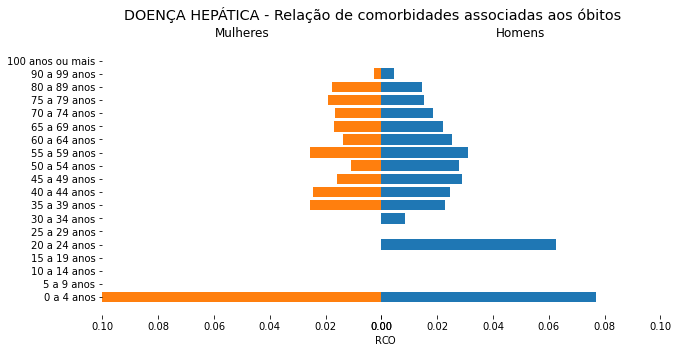

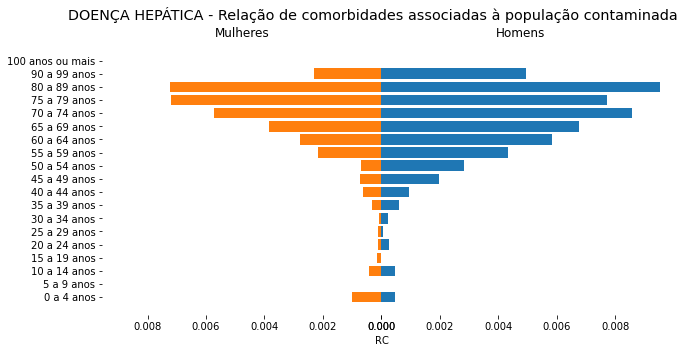

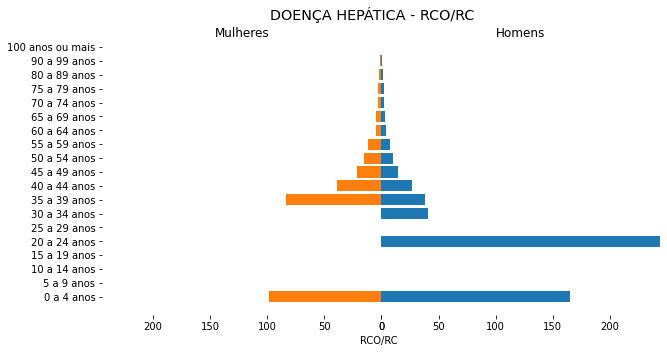

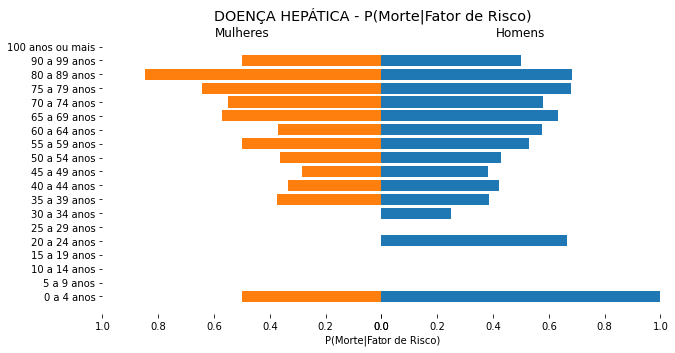

In [95]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'doenca_hepatica_pre',"doença hepática")

#### DOENCA NEUROLOGICA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


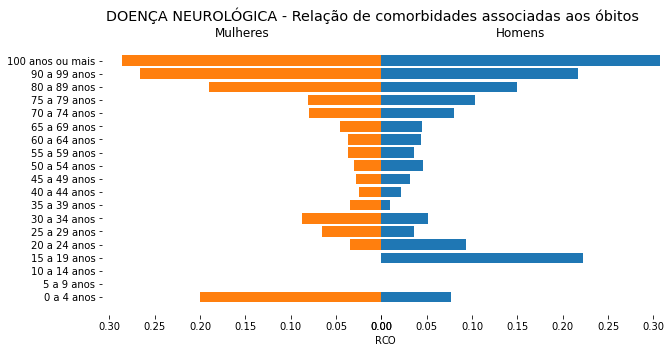

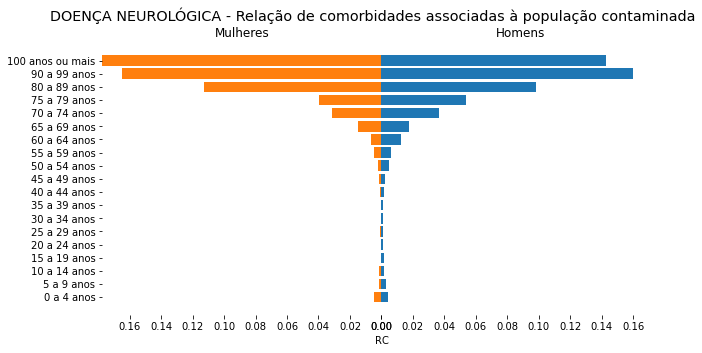

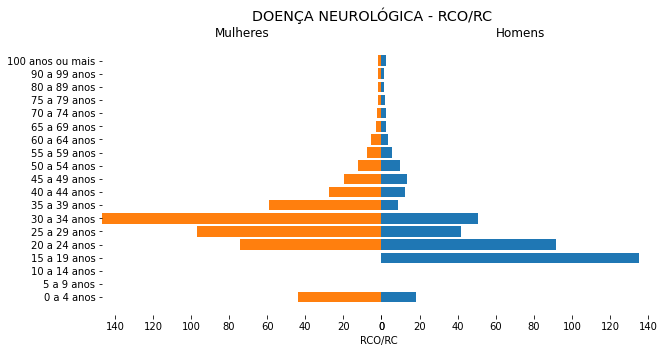

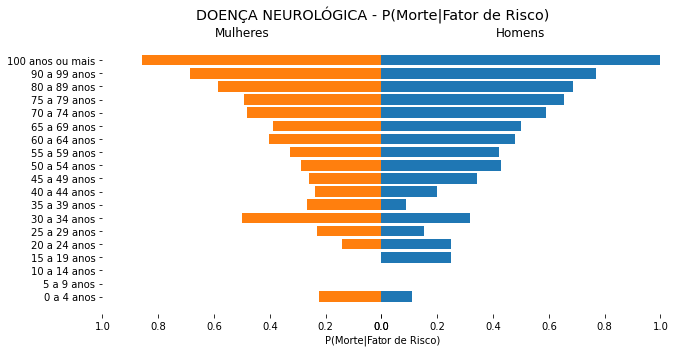

In [96]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'doenca_neurologica_pre',"doença neurológica")

#### DOENCA RENAL

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


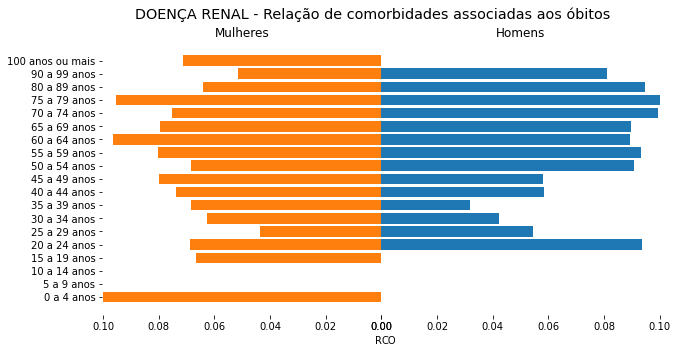

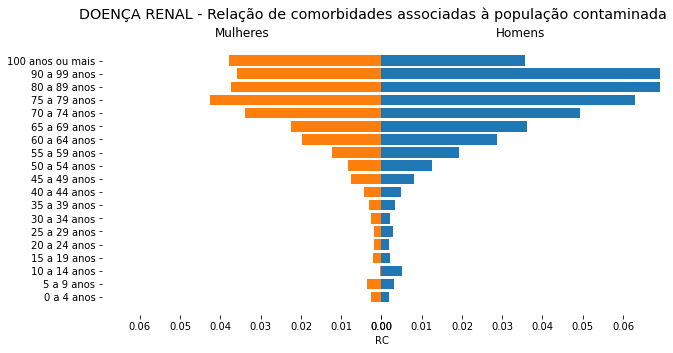

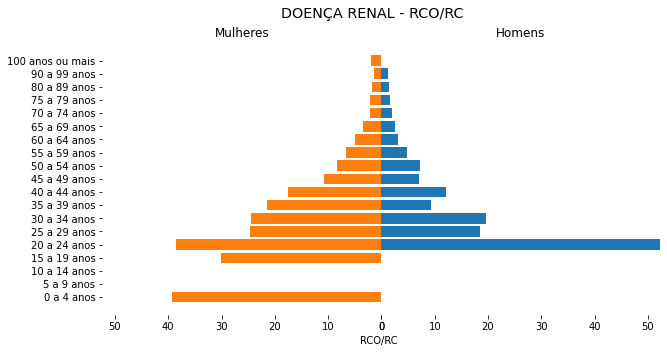

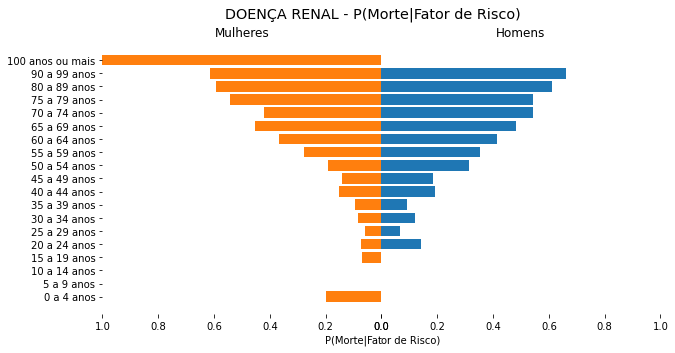

In [97]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'doenca_renal_pre',"doença renal")

#### IMUNODEPRESSÃO

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


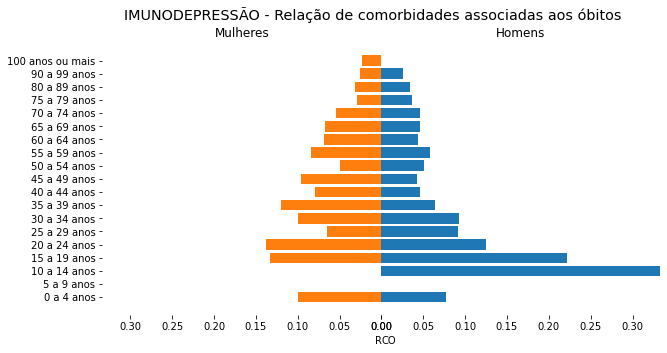

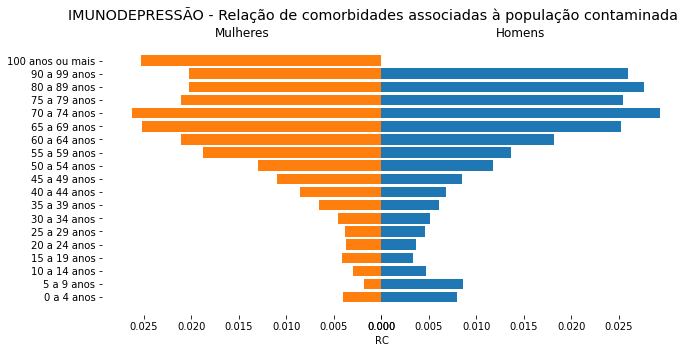

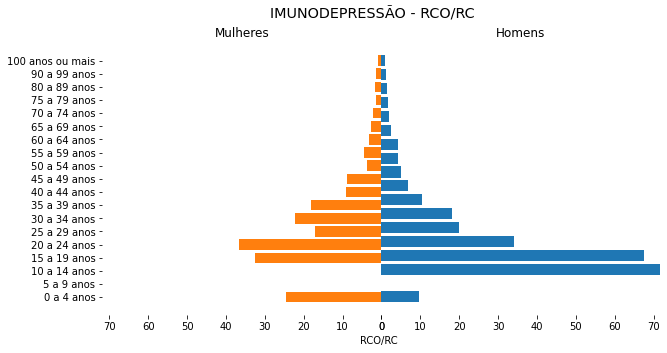

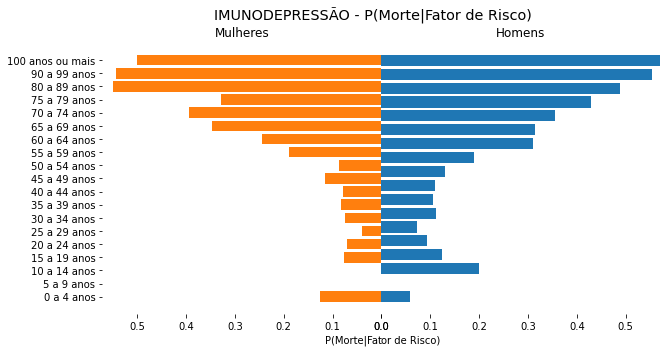

In [98]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'imunodepressao_pre',"imunodepressão")

#### OBESIDADE

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


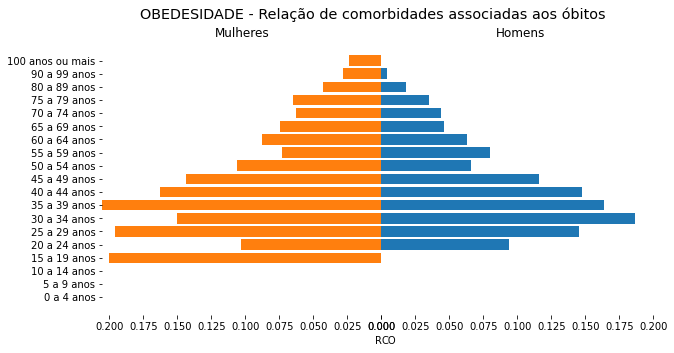

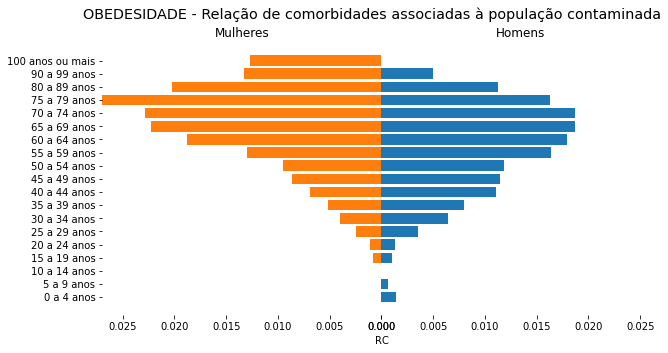

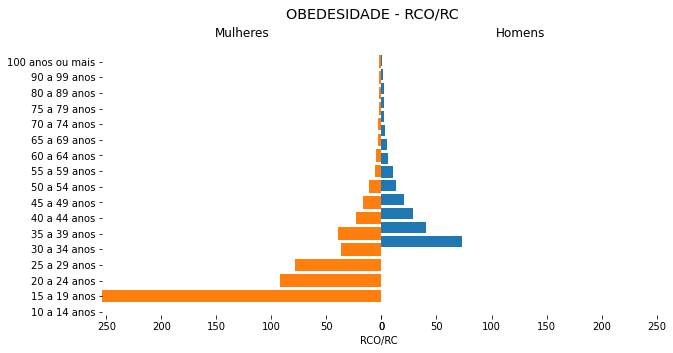

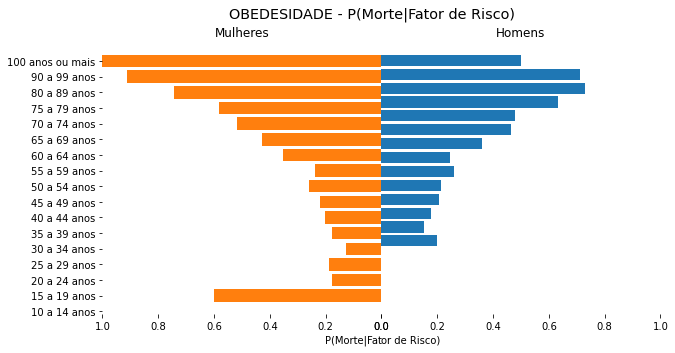

In [99]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'obesidade_pre',"obedesidade")

#### OUTROS FATORES DE RISCO

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


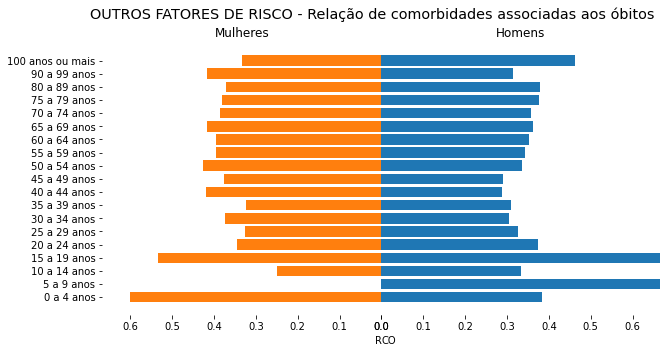

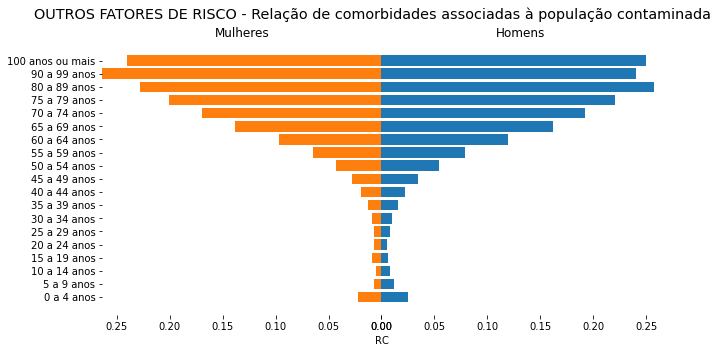

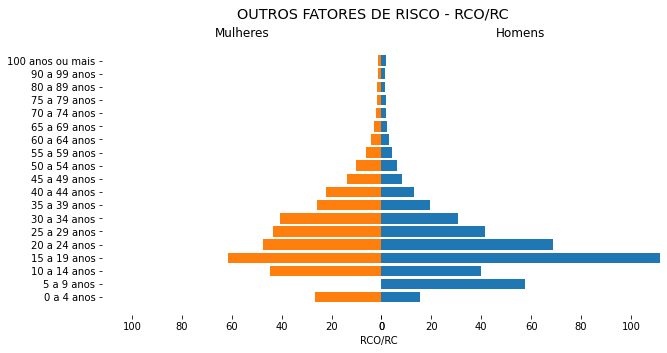

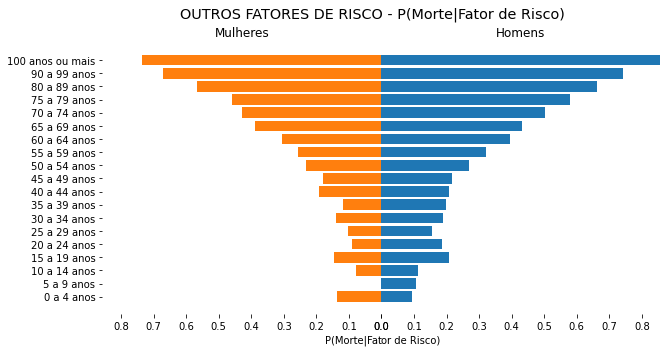

In [100]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'outros_fatores_de_risco_pre',"outros fatores de risco")

#### CARDIOPATIA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


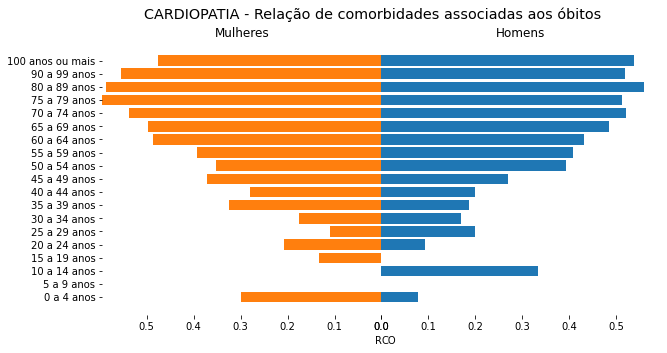

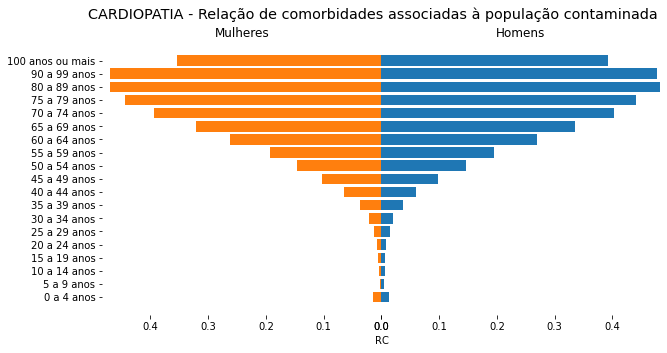

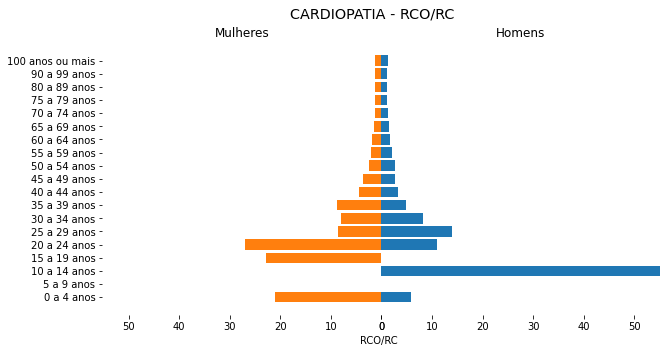

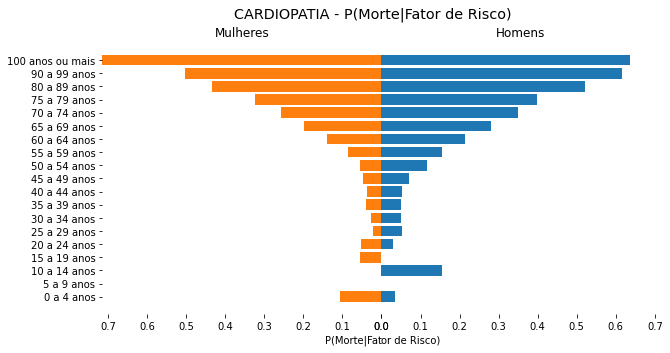

In [101]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'cardiopatia_pre',"cardiopatia")

#### PNEUMOPATIA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


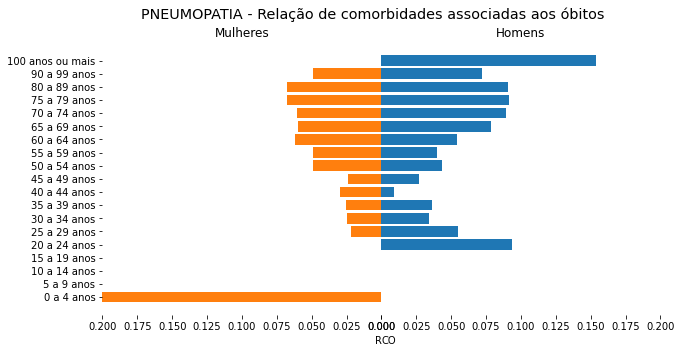

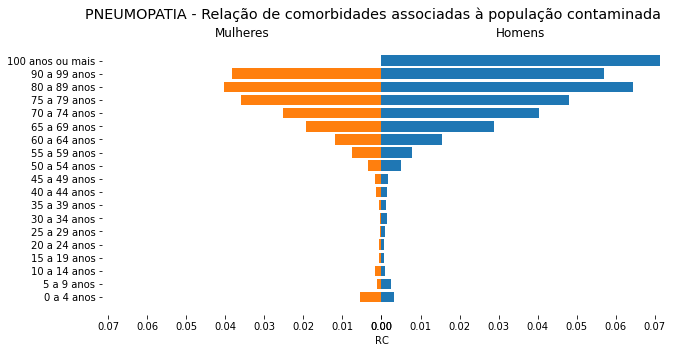

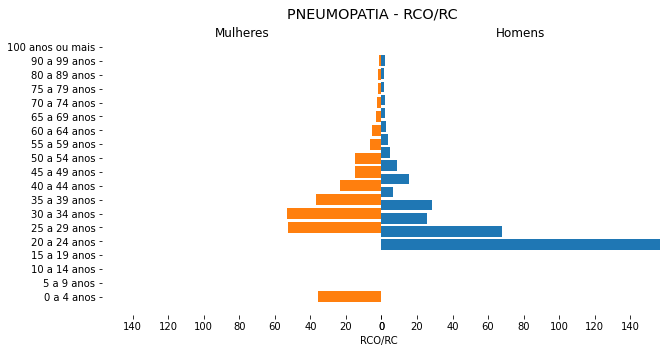

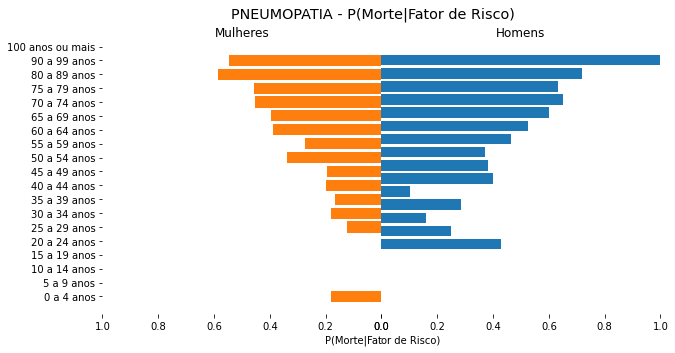

In [102]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'pneumopatia_pre',"pneumopatia")

#### PUERPERA

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars


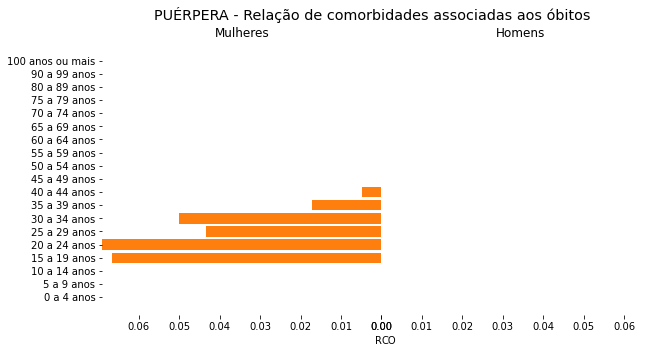

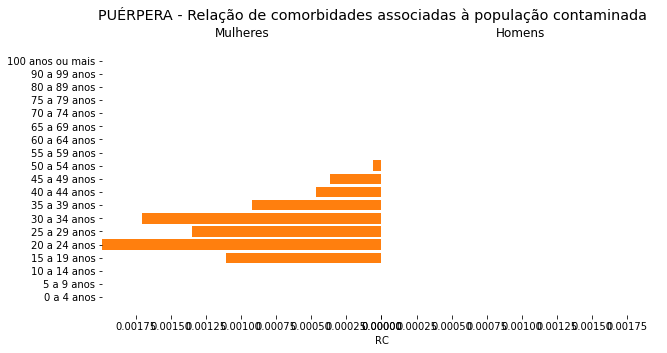

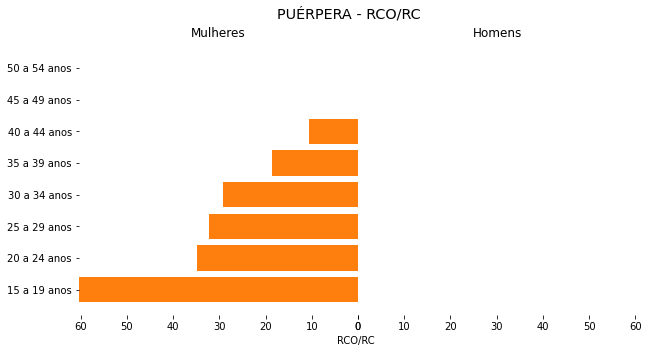

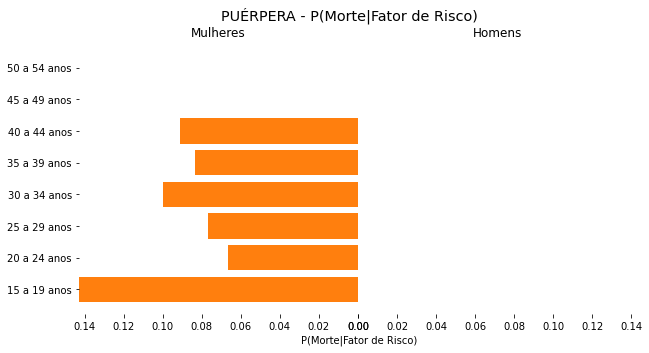

In [103]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'puerpera_pre',"puérpera")

#### SINDROME DE DOWN

C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


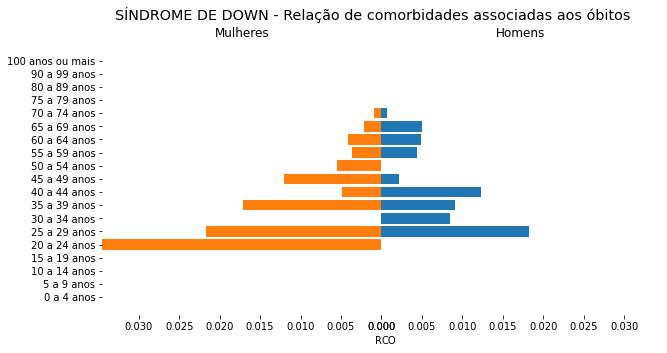

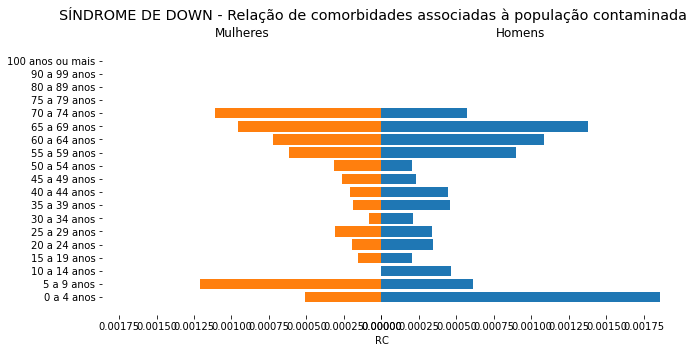

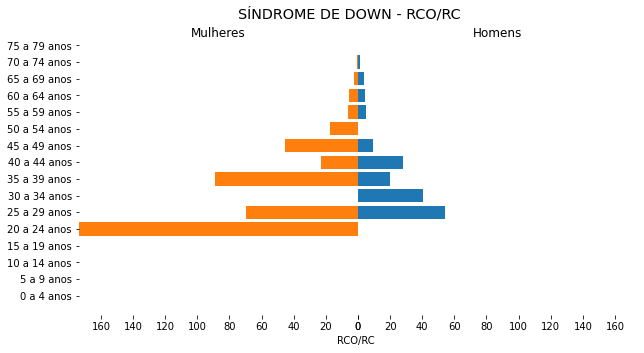

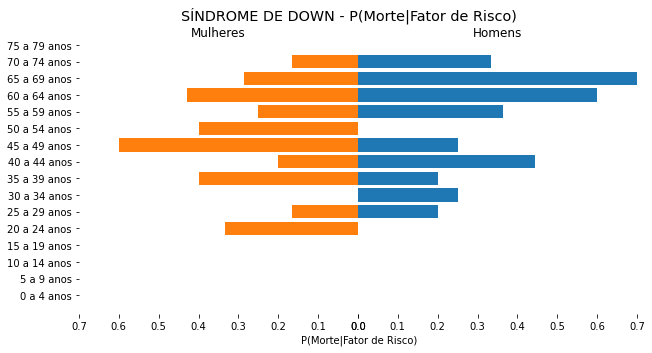

In [104]:
plot_piramides_rc_faixa_etaria_comorbidade(casos_sp_explode,bins,'sindrome_de_down_pre',"síndrome de down")